In [188]:
#.. ... .... .. ....

In [189]:
#import dependencies

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_absolute_error as mae


import warnings
from tqdm.notebook import tqdm_notebook as bar
from datetime import datetime, timedelta

from pyextremes import get_extremes
from pyextremes.plotting import plot_extremes
from pyextremes import plot_mean_residual_life

from pyextremes import plot_parameter_stability
import scipy.fftpack as fftpack
from scipy.integrate import RK45
pd.set_option('display.max_rows', 100)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import optuna
from sklearn.linear_model import LinearRegression

from pykrige.ok import OrdinaryKriging

warnings.filterwarnings("ignore")

In [190]:
#importing raw data retrieved from ASOS for the site of study.

df1 = pd.read_csv("C://Users//AS19030//Desktop//ETS//Winter-2023//DGA-1032//Dissertation//asos (2).csv",
                  parse_dates=[1])

df2 = pd.read_csv("C://Users//AS19030//Desktop//ETS//Winter-2023//DGA-1032//Dissertation//asos (3).csv",
                  parse_dates=[1])

df3 = pd.read_csv("C://Users//AS19030//Desktop//ETS//Winter-2023//DGA-1032//Dissertation//asos (4).csv",
                  parse_dates=[1])

df4 = pd.read_csv("C://Users//AS19030//Desktop//ETS//Winter-2023//DGA-1032//Dissertation//asos (5).csv",
                  parse_dates=[1])

df5 = pd.read_csv("C://Users//AS19030//Desktop//ETS//Winter-2023//DGA-1032//Dissertation//asos (6).csv",
                  parse_dates=[1])


# Concatenation
df = pd.DataFrame()
df = df.append(df1)
df = df.append(df2)
df = df.append(df3)
df = df.append(df4)
df = df.append(df5)
df.fillna(0, 
         inplace= True)


df.set_index("valid",
            inplace=True)


df

,station,lon,lat,elevation,tmpc,relh,drct,sped,p01m,ice_accretion_1hr,ice_accretion_3hr,ice_accretion_6hr
valid,,,,,,,,,,,,
1941-11-05 13:00:00,CYVP,-68.4269,58.0961,60.0,0.20,95.74,360.0,12.65,0.0,0.0,0.0,0.0
1941-11-05 14:00:00,CYVP,-68.4269,58.0961,60.0,0.80,100.00,23.0,17.25,0.0,0.0,0.0,0.0
1941-11-05 15:00:00,CYVP,-68.4269,58.0961,60.0,0.80,95.76,360.0,19.55,0.0,0.0,0.0,0.0
1941-11-05 16:00:00,CYVP,-68.4269,58.0961,60.0,0.80,95.76,23.0,17.25,0.0,0.0,0.0,0.0
1941-11-05 17:00:00,CYVP,-68.4269,58.0961,60.0,1.30,92.37,23.0,11.50,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-16 23:00:00,CWDT,-71.1683,49.8403,399.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0
2023-04-16 23:00:00,CWKD,-71.0131,50.7289,497.0,10.72,41.00,0.0,0.00,0.0,0.0,0.0,0.0
2023-04-16 23:00:00,CWEE,-73.3556,49.2786,305.0,9.89,52.03,0.0,0.00,0.0,0.0,0.0,0.0


In [3]:
# Correction of mean wind speed
# Assumptions:
#             the terrain is open
#             the elevation of anemometer from the surface is 27 ft (8.2296 m)
alpha = 0.16

df.sped = df.sped*(10/8.2296)**alpha

In [191]:
#filter meteorological parameter to identify freezing rain events

df = df.loc[(df.tmpc <= 2)&     # upper bound of ambient temperature
            (df.tmpc >= -10)&   # lower bound of ambient temperature 
            (df.p01m >  0)&     # exclusion of records without precipitation
            (df.p01m <= 30)&    # maximum hourly precipitation is 10 mm (based on the climate.weather.gc.ca)
            (df.relh >= 80)&    # omitting of records with low relative humidity
            (df.sped > 0)&      # windy condition!
            (df.sped <= 20)]    # Strong winds are unlikely to happen during freezing rain events.
df

,station,lon,lat,elevation,tmpc,relh,drct,sped,p01m,ice_accretion_1hr,ice_accretion_3hr,ice_accretion_6hr
valid,,,,,,,,,,,,
2000-01-07 21:00:00,CWDT,-71.1683,49.8403,399.0,-5.78,88.38,270.0,8.05,1.02,0.0,0.0,0.0
2000-01-07 21:00:00,CWQH,-71.8236,45.3689,181.0,-0.22,100.00,230.0,8.05,1.27,0.0,0.0,0.0
2000-01-07 21:00:00,CWEE,-73.3556,49.2786,305.0,-6.11,88.35,190.0,1.15,1.02,0.0,0.0,0.0
2000-01-26 07:00:00,CWNQ,-72.6572,46.2258,10.0,-6.28,88.34,10.0,11.50,1.02,0.0,0.0,0.0
2000-01-26 08:00:00,CWJB,-71.2875,46.7803,91.0,-4.89,96.28,40.0,10.35,1.02,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-12 14:00:00,CWSF,-65.3247,49.2508,29.0,1.22,96.46,290.0,16.10,1.27,0.0,0.0,0.0
2023-04-12 18:00:00,CWGR,-61.8000,47.4200,60.0,1.78,96.10,350.0,13.80,0.25,0.0,0.0,0.0
2023-04-12 21:00:00,CWGR,-61.8000,47.4200,60.0,1.39,95.70,330.0,16.10,0.25,0.0,0.0,0.0


In [192]:
# Removing unnecessary colunms

df.drop(labels=["tmpc", "relh", "drct", "ice_accretion_1hr", "ice_accretion_3hr", "ice_accretion_6hr"],
       axis = 1, inplace = True)

df


,station,lon,lat,elevation,sped,p01m
valid,,,,,,
2000-01-07 21:00:00,CWDT,-71.1683,49.8403,399.0,8.05,1.02
2000-01-07 21:00:00,CWQH,-71.8236,45.3689,181.0,8.05,1.27
2000-01-07 21:00:00,CWEE,-73.3556,49.2786,305.0,1.15,1.02
2000-01-26 07:00:00,CWNQ,-72.6572,46.2258,10.0,11.50,1.02
2000-01-26 08:00:00,CWJB,-71.2875,46.7803,91.0,10.35,1.02
...,...,...,...,...,...,...
2023-04-12 14:00:00,CWSF,-65.3247,49.2508,29.0,16.10,1.27
2023-04-12 18:00:00,CWGR,-61.8000,47.4200,60.0,13.80,0.25
2023-04-12 21:00:00,CWGR,-61.8000,47.4200,60.0,16.10,0.25


In [195]:
# Calculation of liquid water content

df["lwc"] = 0.067*(df.p01m**0.846)     # Best model (1949)

df.reset_index(inplace=True)



In [198]:
# For some cases, the accumulation of ice can be tracked as the records are consistent (continuous); however,
# in some situations the records include several measurements within an hour.

count = 0
for val in df.groupby([df.station, df.valid.dt.month, df.valid.dt.day, df.valid.dt.hour]):
    val = val[1]
    if val.shape[0] > 1:
        count += 1


print(f'The times that one value has been reported more than once within one hour: \033[1m{count:.0f}\033[0m.')

The times that one value has been reported more than once within one hour: 36014.


In [199]:
# In this step, the hourly ice accretion is computed.

# Assumptions:
#             Hydometeor is freezing rain! the ice palette and sleet are disregarded.
#             The ice accretion preserves its characteristics during accretion (the ice type is assumed to be glaze).
#             The latent value recorded in each hour at each station is considered at the representative of mean wind speed.

ro_0 = 1.0    # density of hydrometeor
ro_i = 0.9    # density of glaze

df['Ri'] = 0

df["Ri"] = np.sqrt((df.p01m)**2 +\
                        (3.6*df.sped*df.lwc)**2)




temp = pd.DataFrame()

stns = df.station.unique()

for station in bar(stns):
    
    df0 = df.loc[df.station == station].copy() #extracting the data recorded at each station
    
    df0.sort_values("valid", inplace=True)     # Sorting measurements based on date
    
    for val in df0.groupby([df0.valid.dt.month, df0.valid.dt.day, df0.valid.dt.hour]):            # Looking for multiple measurements within an hour.
        val = val[1]
        
        
            
        temp = temp.append(val)



  0%|          | 0/63 [00:00<?, ?it/s]

In [200]:
df = temp


df.sort_index(inplace=True)
df.reset_index(inplace = True)

if 'index' in df.columns:
    df.drop(labels= 'index',
           axis = 1, inplace = True)

# Removing needless parameters
if 'p01m' in df.columns or 'lwc' in df.columns:
    df.drop(labels = ['p01m', 'lwc'],
           axis = 1, inplace= True)




    
df.describe()

,lon,lat,elevation,sped,Ri
count,155519.000000,155519.000000,155519.000000,155519.000000,155519.000000
mean,-70.508677,47.607912,195.160977,7.705789,2.482946
std,3.974798,1.646187,220.720224,4.564305,2.469001
min,-79.870000,44.850000,4.000000,1.150000,0.264329
25%,-73.349400,46.225800,47.000000,4.600000,0.935789
50%,-71.148300,47.411100,133.000000,6.900000,1.740526
75%,-69.548600,48.894200,239.000000,10.350000,3.239496
max,-59.639400,50.728900,803.000000,19.550000,79.333874


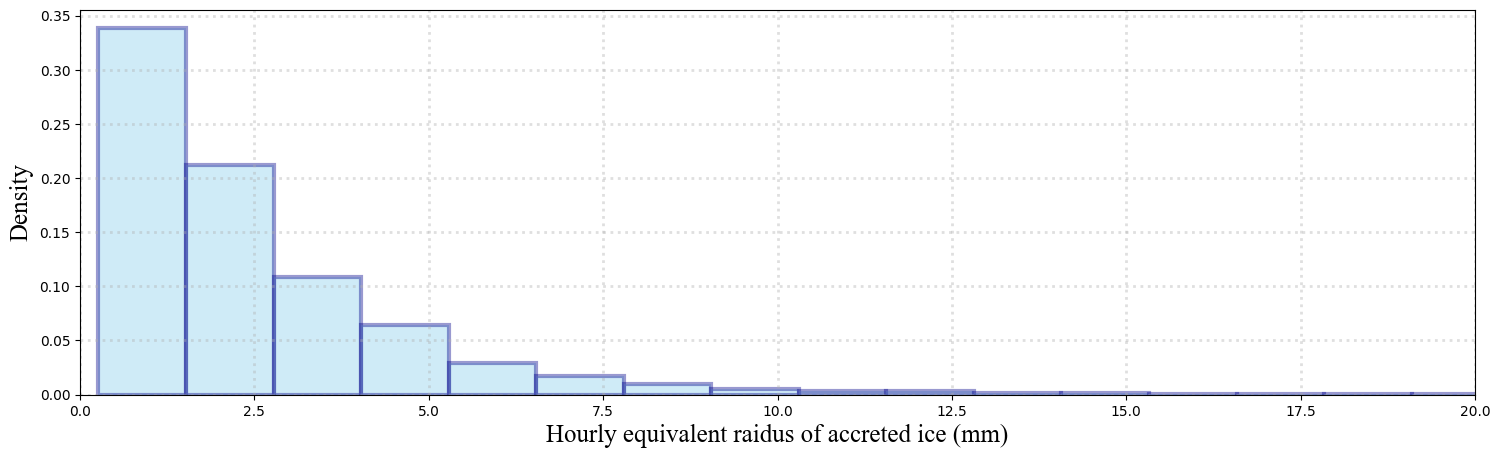

In [211]:
plt.figure(1, figsize = [18, 5])

plt.hist(df.Ri, density = True,
           lw = 3, linestyle='-',
           edgecolor = 'darkblue', fill=True, 
           bins = 63, color = 'skyblue', alpha = 0.4)


plt.xlabel("Hourly equivalent raidus of accreted ice (mm)", 
          fontsize= 18, fontname = "times new roman")

plt.ylabel("Density", 
          fontsize= 18, fontname = "times new roman")

plt.xlim(0, 20)
plt.grid("grey", linestyle = ":",
        alpha = 0.4, linewidth = 2)

In [230]:
def total_ice_layer(r):
# This function is responsible for calculating of total ice
    
    r = r*2e-3 # unit conversion!(radius --> diameter)
    Mass = 0 # Mass of accreted ice layer

    for row, val in enumerate(r):
        if row == 0:
            Mass = np.pi/4*val**2
        else:
            try:
                Mass = np.pi/4*(r[row - 1])**2
                diff = np.pi/4*val**2 - Mass

                r_new = (diff/(np.pi/4) + (r[row - 1])**2)**0.5

                r[row] = r_new
            except:
                print(r)
                raise ValueError('')
            
    return r*0.5*1e3 # unit conversion! (diameter --> radius)
                
            
            

In [232]:
# Now total ice accreteion is computed by adding the total mass of accreted ice layer.
df_processed = pd.DataFrame()
date = pd.Series([])

for station in bar(stns):         # Exctracting data for each station
    R_temp = np.array([])
    sped_temp = np.array([])
    date_temp = pd.Series([])
    
    temp = df.loc[df.station == station].copy()
    temp.valid = pd.to_datetime(temp.valid)
    
    R = temp.groupby(pd.Grouper(key = 'valid', freq = '84H'))['Ri']
    date = temp.groupby(pd.Grouper(key = 'valid', freq = '84H'))['valid']
    
    for dt in date:
        dt = dt[1]
        date_temp = date_temp.append(pd.Series(dt.values))

    for r in R:
        r = r[1]
        r = total_ice_layer(r.values) #total ice            
        R_temp = np.append(R_temp, r)
    
    sped = temp.groupby(pd.Grouper(key = 'valid', freq = '84H'))['sped']
    
    for V in sped:
        V = V[1]
        sped_temp = np.append(sped_temp, V)
                
    lon = np.ones(sped_temp.shape)
    lat = np.ones(sped_temp.shape)
    elev = np.ones(sped_temp.shape)
    
    lon *= temp.iloc[0, 2]
    lat *= temp.iloc[0, 3]
    elev *= temp.iloc[0, 4]
    
    df0 = pd.DataFrame(np.transpose([ lon, lat, elev, sped_temp, R_temp]),
                      columns=['lon','lat', 'elevation', 'sped', 'R'])

    df0['station'] = station

    df0['valid'] = date_temp.values
    
    df_processed = df_processed.append(df0)

df_processed = df_processed[['valid', 'station', 'lon', 'lat', 'elevation', 'sped', 'R']]

df_processed

  0%|          | 0/63 [00:00<?, ?it/s]

,valid,station,lon,lat,elevation,sped,R
0,2000-01-07 21:00:00,CWDT,-71.1683,49.8403,399.0,8.05,2.222364
1,2000-04-09 23:00:00,CWDT,-71.1683,49.8403,399.0,18.40,8.329759
2,2001-01-06 17:00:00,CWDT,-71.1683,49.8403,399.0,2.30,1.165609
3,2001-01-06 18:00:00,CWDT,-71.1683,49.8403,399.0,2.30,5.267748
4,2001-01-06 20:00:00,CWDT,-71.1683,49.8403,399.0,1.15,1.058282
...,...,...,...,...,...,...,...
81,2023-01-18 21:00:00,CWIP,-66.4339,50.1625,25.0,5.75,0.935789
82,2023-02-16 16:00:00,CWIP,-66.4339,50.1625,25.0,5.75,4.324329
83,2023-03-07 05:00:00,CWIP,-66.4339,50.1625,25.0,5.75,0.935789
84,2023-04-12 02:00:00,CWIP,-66.4339,50.1625,25.0,6.90,6.792444


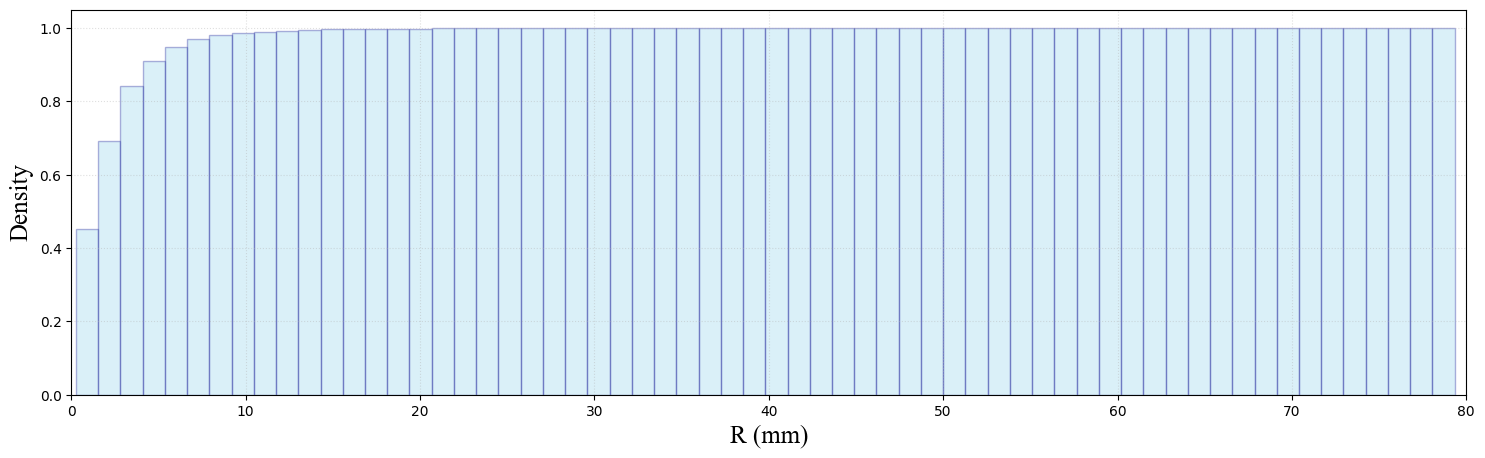

In [236]:
plt.figure(1, figsize = [18, 5])
_ = plt.hist(df_processed.R, density = True, cumulative=True,alpha = 0.3, bins = 62, color = 'skyblue', ec = 'darkblue')
plt.xlim(0, 80)
plt.grid("grey", linestyle = ":",
        alpha = 0.4, )
plt.xlabel("R (mm)", 
          fontsize= 18, fontname = "times new roman")

plt.ylabel("Density", 
          fontsize= 18, fontname = "times new roman")
_ = plt.show()

In [237]:
# Converting 2-min wind speed to 3-sec. gust wind speed
gust_factor = 1.33

df_processed.sped *= gust_factor

In [ ]:
# it is a sample that shows sparsity of the data

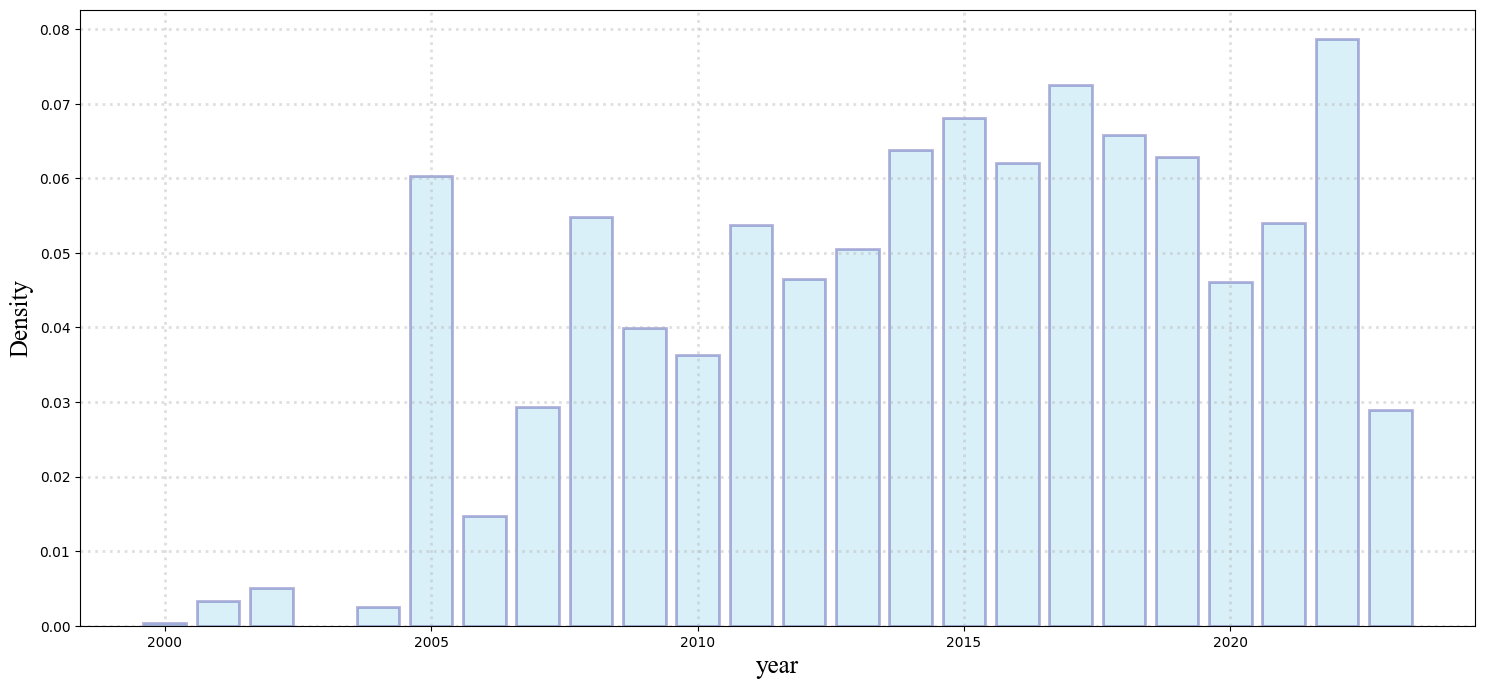

In [249]:
R0 = df_processed.loc[df_processed.station == 'CWBY', ['valid', 'R']]

plt.subplots(1, figsize = [18, 8])

R1 = R0.groupby(R0.valid.dt.year).agg({'R':'count'})

_ = plt.bar(list(R1.index.to_numpy().reshape(-1, )), R1.to_numpy().reshape(-1, )/R0.shape[0], color='skyblue', alpha = 0.3, ec= 'darkblue', lw = 2)
plt.xticks()
plt.xlabel("year", 
          fontsize= 18, fontname = "times new roman")

plt.ylabel("Density", 
          fontsize= 18, fontname = "times new roman")


plt.grid("grey", linestyle = ":",
        alpha = 0.4, linewidth = 2)

In [475]:
# identifying threshold for ice accretion and wind speed

(<Figure size 768x768 with 4 Axes>,
 (<Axes: title={'center': 'Return value plot'}, xlabel='Return period', ylabel='R'>,
  <Axes: title={'center': 'Probability density plot'}, xlabel='R', ylabel='Probability density'>,
  <Axes: title={'center': 'Q-Q plot'}, xlabel='Theoretical', ylabel='Observed'>,
  <Axes: title={'center': 'P-P plot'}, xlabel='Theoretical', ylabel='Observed'>))

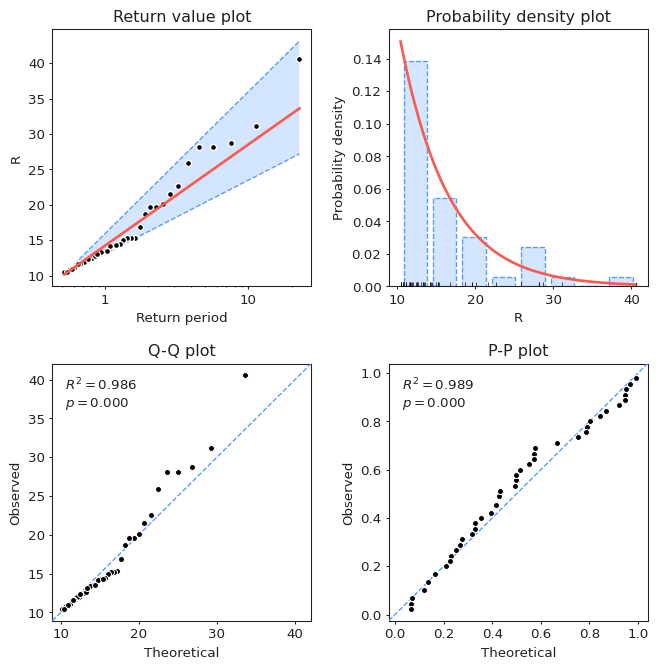

In [545]:
model = EVA(R)
model.get_extremes(method="POT", threshold = 10, r="432H")

model.fit_model()
model.plot_diagnostic(alpha = 0.98)

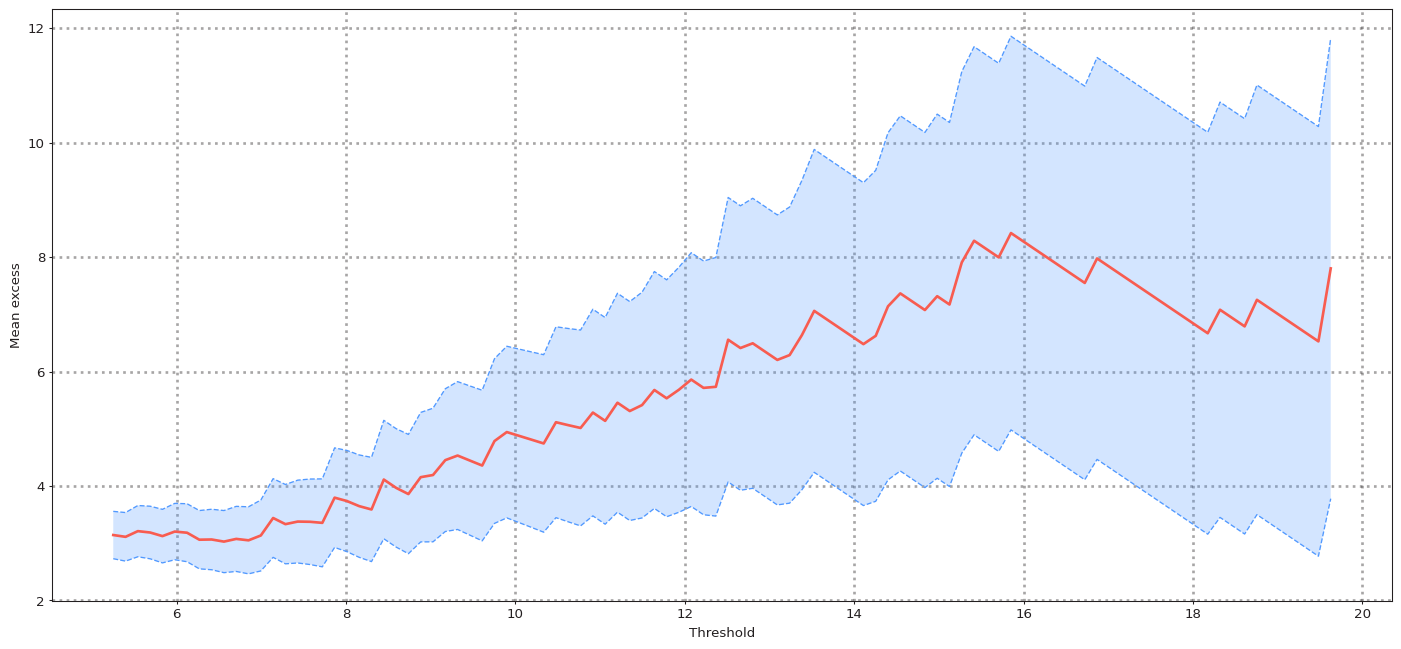

In [529]:
R = df_processed.loc[df.station == 'CWEW', ['valid', 'R']].drop_duplicates(subset = 'valid')
R.set_index('valid', inplace= True)
R = R.astype(float).squeeze()
R.sort_index(ascending = True, inplace=True)


_ = plot_mean_residual_life(R, figsize=[18, 8])
plt.grid("grey", linestyle = ":",
        alpha = 0.4, linewidth = 2)
plt.show()

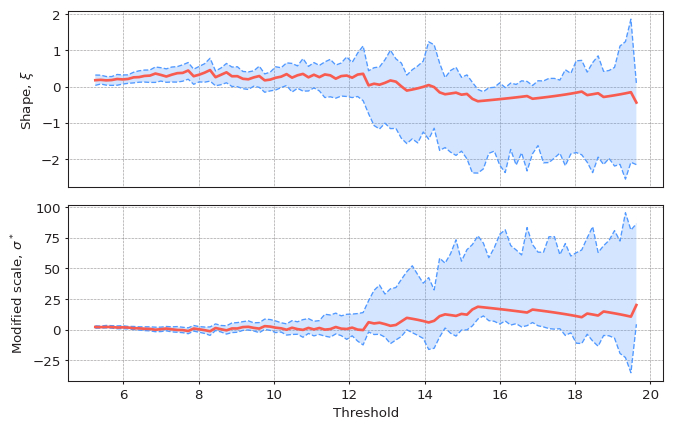

In [530]:

plot_parameter_stability(R, alpha = 0.95)

plt.show()

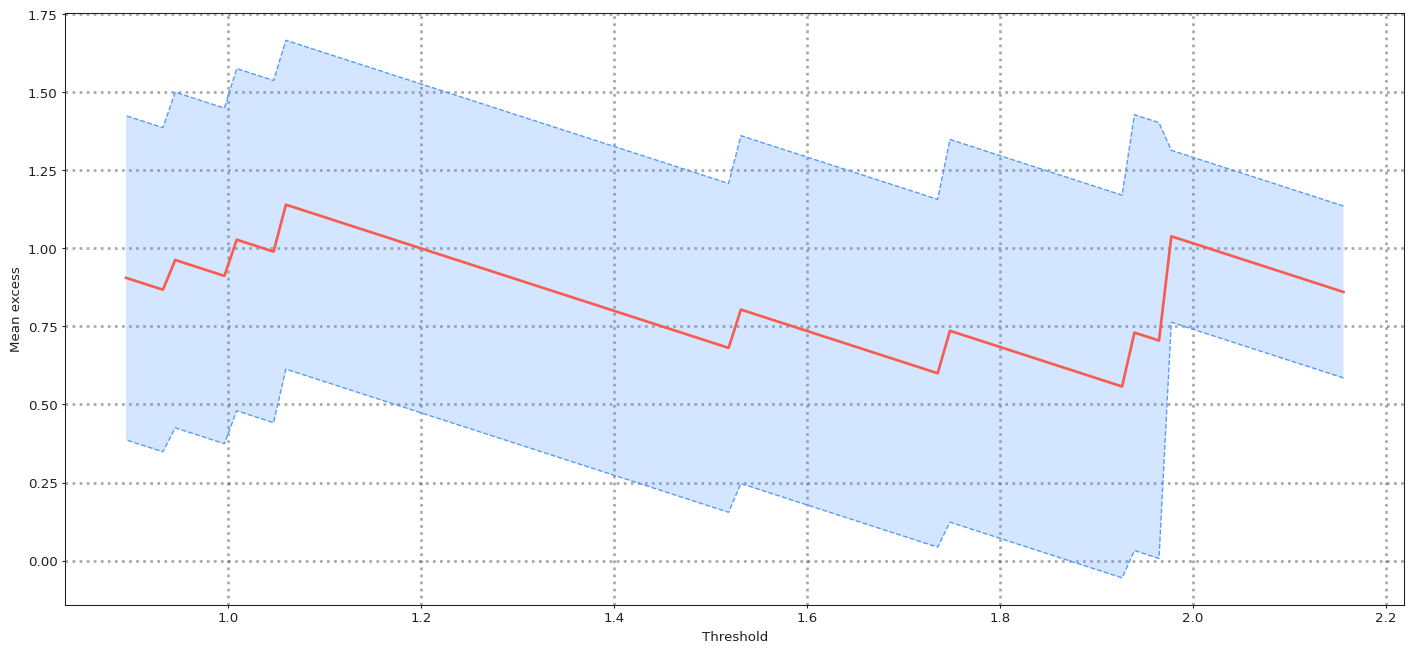

In [960]:
V = df_processed.loc[df.station == 'CXSH', ['valid', 'R']].drop_duplicates(subset = 'valid')
V.set_index('valid', inplace= True)
V = V.astype(float).squeeze()
V.sort_index(ascending = True, inplace=True)


_ = plot_mean_residual_life(V, figsize=[18, 8])
plt.grid("grey", linestyle = ":",
        alpha = 0.4, linewidth = 2)
plt.show()

In [587]:
Rextremes.reset_index(inplace=True)
Vextremes.reset_index(inplace=True)

In [1628]:
Rvals = Rextremes.loc[Rextremes.period == 50, 'value']


In [588]:
Rextremes.rename(columns={'return period':'period', 'return value':'value'}, inplace=True)
Vextremes.rename(columns={'return period':'period', 'return value':'value'}, inplace=True)

In [593]:
thresholds = pd.read_excel('C://Users//AS19030//Desktop//ETS//Winter-2023//DGA-1032//Dissertation//thresholds.xlsx',
                          header=[1])

thresholds = thresholds.loc[(thresholds.ice_threshold > 0)]


In [1229]:
Vdata = pd.DataFrame()
for station in bar(columns):
    
    threshold = thresholds.loc[thresholds.Station == station]
    
    try:
        r_threshold = threshold.iloc[:, 2].values[0]

        R = df_processed.loc[df_processed.station == station, ['valid', 'sped']].drop_duplicates(subset = 'valid')
        R.set_index('valid', inplace= True)
        R = R.astype(float).squeeze()
        R.sort_index(ascending = True, inplace=True)
        
        modelR = EVA(R)

        modelR.get_extremes(method="POT", threshold = r_thresholda, r="432H")

        modelR.fit_model()
        
        r = modelR.get_summary(return_period=[10, 25, 50, 75, 100],
                                    alpha=0.95, n_samples=10_000,
                                   )
        Vdata = Vdata.append(r)
        
        r = r.iloc[:, 0].values
        print(f" {station}: {df_processed.loc[df_processed.station == station, 'lon'].ravel()[0]}, {df_processed.loc[df_processed.station == station, 'lat'].ravel()[0]}, {df_processed.loc[df_processed.station == station, 'elevation'].ravel()[0]}, {r[0]:.3f}, {r[1]:.3f}, {r[2]:.3f}, {r[3]:.3f}, {r[4]:.3f}")
    except:
        
        
        continue
        
print('************------------************')
print('               done ! ')
print('************------------************')

  0%|          | 0/63 [00:00<?, ?it/s]

 CWDT: -71.1683, 49.8403, 399.0, 25.969, 25.996, 26.000, 26.001, 26.001
 CWQH: -71.8236, 45.3689, 181.0, 25.918, 25.983, 25.996, 25.998, 26.000
 CWEE: -73.3556, 49.2786, 305.0, 16.625, 16.765, 16.801, 16.811, 16.815
 CWNQ: -72.6572, 46.2258, 10.0, 25.998, 26.001, 26.001, 26.001, 26.001
 CWJB: -71.2875, 46.7803, 91.0, 25.958, 25.995, 26.000, 26.001, 26.001
 CWTA: -73.5793, 45.5049, 63.0, 21.085, 22.018, 22.476, 22.676, 22.794
 CWSF: -65.3247, 49.2508, 29.0, 25.699, 25.930, 25.978, 25.989, 25.993
 CWIZ: -73.3494, 45.2939, 45.0, 25.986, 25.999, 26.001, 26.001, 26.001
 CWIT: -73.6789, 45.1672, 52.0, 25.846, 25.964, 25.989, 25.995, 25.997
 CWTG: -67.3811, 49.3167, 5.0, 25.988, 26.000, 26.001, 26.001, 26.001
 CWHV: -70.785, 46.205, 229.0, 24.351, 25.235, 25.627, 25.785, 25.875
 CWMJ: -75.9919, 46.2747, 200.0, 25.586, 25.856, 25.936, 25.960, 25.972
 CWJO: -71.1426, 48.425, 133.0, 25.990, 26.000, 26.001, 26.001, 26.001
 CXBO: -71.1972, 46.8369, 100.0, 25.942, 25.992, 25.999, 26.000, 26.001
 CW

In [1446]:


# Split data into features and target
X = Rvals.drop(['station', 'rval', 'residuals'], axis=1)
y = Rvals['rval'].to_numpy().reshape(-1, 1)

# Create a Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X, y)

# Get the feature importance scores
importance_scores = model.coef_
# Get the feature importance scores as a list of tuples
importance_scores = [(feature, score) for feature, score in zip(X.columns, model.coef_)]

# Sort the feature importance scores in descending order of importance
importance_scores = sorted(importance_scores, key=lambda x: abs(x[1]), reverse=True)

# Print the feature importance scores
for feature, score in importance_scores:
    print(f'{feature}: {score}')

lon: [0.14685516 1.15504496 0.00615834]


In [984]:
# Define the problem statement
input_size = 2
output_size = 1
hidden_layers = 2
activation = nn.ReLU()
initialization = nn.init.xavier_uniform_
loss_fn = nn.MSELoss()
optimizer = optim.Adam

epochs = 400
val_ratio = 0.15
test_ratio = 0.15


In [1036]:
X = Rvals.iloc[:, [2, 3]].to_numpy()

R = Rvals.iloc[:, -1].to_numpy().reshape(-1, 1)

scaleX = MinMaxScaler()
scaleR = MinMaxScaler()

X = scaleX.fit_transform(X)
R = scaleR.fit_transform(R)

In [1037]:
X_train, x_test, y_train, y_test = train_test_split(X, R, test_size=test_ratio)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio)





In [1038]:
class Net(nn.Module):
    def __init__(self, n_input, n_output,  n_neurons1, activation_func):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_input, n_neurons1)
        self.fc2 = nn.Linear(n_neurons1, n_neurons1)
        self.fc3 = nn.Linear(n_neurons1, n_output)
        self.activation_func = activation_func
        
    def forward(self, x):
        x = self.activation_func(self.fc1(x))
        x = self.activation_func(self.fc2(x))
        x = self.fc3(x)
        return x

In [1043]:
def objective(trial):
    # Define the number of neurons and learning rate for this trial
    n_neurons1 = trial.suggest_int('n_neurons1', 2, 50)
#     n_neurons2 = trial.suggest_int('n_neurons2', 2, 100)
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 16])
    # Define the network architecture
    net = Net(n_input=2, n_output=1, n_neurons1=n_neurons1, activation_func=nn.ReLU())

    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)

    
    # Convert the data to PyTorch tensors and create DataLoader objects
    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
    val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val))
    
    train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size= batch_size, shuffle=False)

    # Train the model
    for epoch in range(4_00):
        net.train()
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = net(x_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            
        net.eval()
        with torch.no_grad():
            val_loss = 0
            for x_batch, y_batch in val_loader:
                y_pred = net(x_batch)
                val_loss += criterion(y_pred, y_batch).item() * x_batch.size(0)
            val_loss /= len(val_loader.dataset)
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    
    return val_loss

In [1044]:
if __name__ == '__main__':
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=100)
    
    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial
    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-04-24 00:58:13,085] A new study created in memory with name: no-name-a827ec88-4ea5-425a-a327-d50b9892b8f6
[I 2023-04-24 00:58:13,584] Trial 0 finished with value: 0.053972285240888596 and parameters: {'n_neurons1': 13, 'lr': 9.293762494505142e-05, 'batch_size': 64}. Best is trial 0 with value: 0.053972285240888596.
[I 2023-04-24 00:58:14,087] Trial 1 finished with value: 0.021905409172177315 and parameters: {'n_neurons1': 38, 'lr': 5.950054425850793e-05, 'batch_size': 32}. Best is trial 1 with value: 0.021905409172177315.
[I 2023-04-24 00:58:14,804] Trial 2 finished with value: 0.01824791356921196 and parameters: {'n_neurons1': 14, 'lr': 6.959862090279995e-05, 'batch_size': 16}. Best is trial 2 with value: 0.01824791356921196.
[I 2023-04-24 00:58:15,289] Trial 3 finished with value: 0.2189415991306305 and parameters: {'n_neurons1': 7, 'lr': 0.00017561855952026895, 'batch_size': 64}. Best is trial 2 with value: 0.01824791356921196.
[I 2023-04-24 00:58:15,886] Trial 4 finished wi

[I 2023-04-24 00:58:27,809] Trial 84 pruned. 
[I 2023-04-24 00:58:27,824] Trial 85 pruned. 
[I 2023-04-24 00:58:27,838] Trial 86 pruned. 
[I 2023-04-24 00:58:27,858] Trial 87 pruned. 
[I 2023-04-24 00:58:27,872] Trial 88 pruned. 
[I 2023-04-24 00:58:27,887] Trial 89 pruned. 
[I 2023-04-24 00:58:27,901] Trial 90 pruned. 
[I 2023-04-24 00:58:28,700] Trial 91 finished with value: 0.019154028967022896 and parameters: {'n_neurons1': 24, 'lr': 0.0022930891805539697, 'batch_size': 16}. Best is trial 9 with value: 0.015616541728377342.
[I 2023-04-24 00:58:28,713] Trial 92 pruned. 
[I 2023-04-24 00:58:28,725] Trial 93 pruned. 
[I 2023-04-24 00:58:28,741] Trial 94 pruned. 
[I 2023-04-24 00:58:28,755] Trial 95 pruned. 
[I 2023-04-24 00:58:28,768] Trial 96 pruned. 
[I 2023-04-24 00:58:28,783] Trial 97 pruned. 
[I 2023-04-24 00:58:28,798] Trial 98 pruned. 
[I 2023-04-24 00:58:28,813] Trial 99 pruned. 


Number of finished trials:  100
Best trial:
  Value:  0.015616541728377342
  Params: 
    n_neurons1: 11
    lr: 0.0019316059258061367
    batch_size: 64


In [1046]:
print("Number of finished trials:", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    

Number of finished trials: 100
Best trial:
  Value:  0.015616541728377342
  Params: 
    n_neurons1: 11
    lr: 0.0019316059258061367
    batch_size: 64


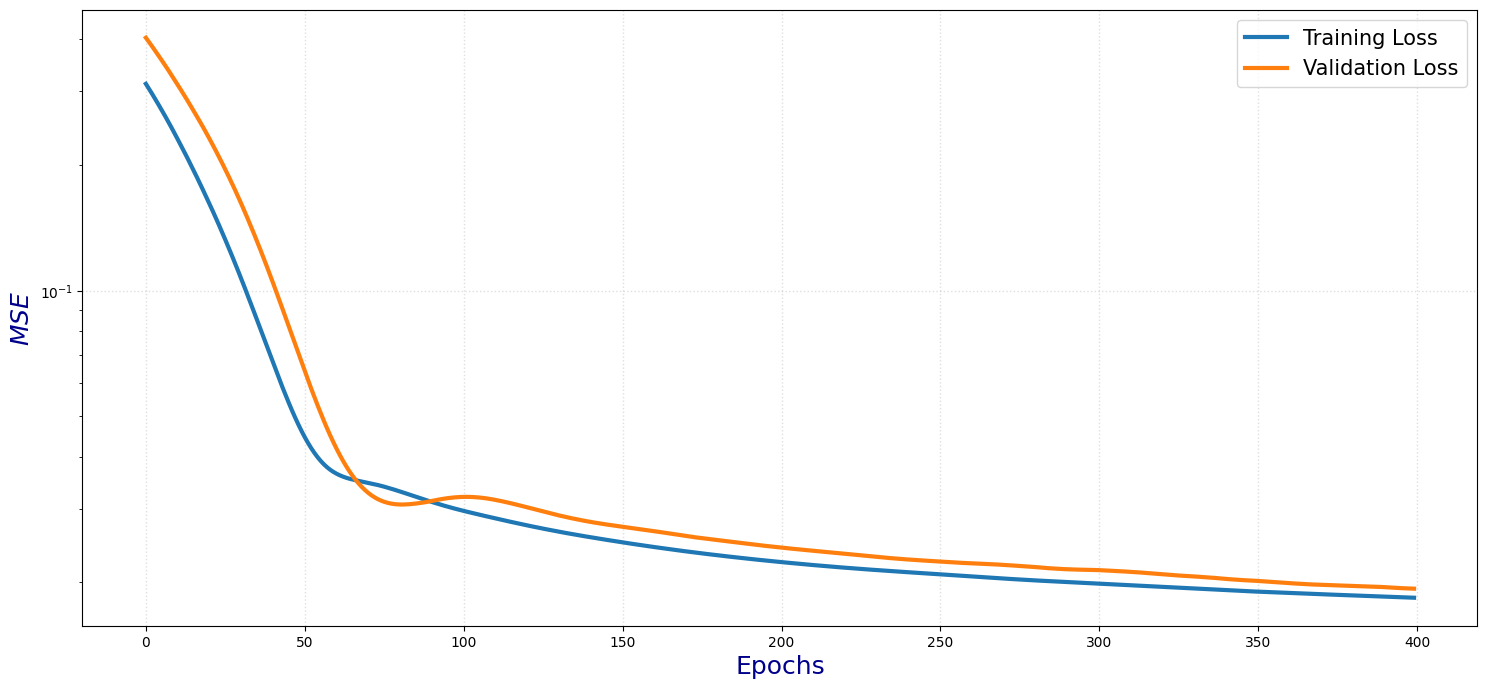

In [1060]:
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
val_dataset = TensorDataset(torch.Tensor(X_val), torch.Tensor(y_val))
train_loader = DataLoader(train_dataset, batch_size= trial.params['batch_size'])
val_loader = DataLoader(val_dataset, batch_size= trial.params['batch_size'])


netR = Net(n_input=2, n_output=1, \
          n_neurons1=trial.params['n_neurons1'],\
          activation_func=nn.ReLU())

criterion = nn.MSELoss()
optimizer = optim.Adam(netR.parameters(), lr=trial.params['lr'])


train_losses, val_losses = [], []
for epoch in range(4_00):
    train_loss = 0.0
    valid_loss = 0.0
    netR.train()
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = netR(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x_batch.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
        
    netR.eval()
    with torch.no_grad():
        val_loss = 0
        for x_batch, y_batch in val_loader:
            y_pred = netR(x_batch)
            valid_loss += criterion(y_pred, y_batch).item() * x_batch.size(0)
        valid_loss /= len(val_loader.dataset)
        val_losses.append(valid_loss)
#     print(f"Epoch {epoch}: train_loss={train_losses[-1]:.4f} val_loss={val_loss:.4f}")
    
# Plot the training and validation loss curves
import matplotlib.pyplot as plt
_, ax = plt.subplots(1, figsize= [18, 8])

plt.plot(train_losses, label='Training Loss', lw= 3)
plt.plot(val_losses, label='Validation Loss', lw= 3)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid("grey", linestyle = ":",
        alpha = 0.4, linewidth = 1)
plt.xlabel("Epochs", c="darkblue", size=18)
plt.ylabel("$MSE$", c="darkblue", size=18)
plt.legend(loc="upper right", prop={"size":15})
plt.show()

In [1066]:
pred_train = netR(torch.Tensor(X_train))
pred_test = netR(torch.Tensor(x_test))

pred_train = pred_train.detach().numpy().reshape(-1, 1)
pred_test = pred_test.detach().numpy().reshape(-1, 1)

mse_train, mae_train, r2_train = mse(pred_train, y_train), mae(pred_train, y_train), r2(pred_train, y_train)
mse_test, mae_test, r2_test = mse(pred_test, y_test), mae(pred_test, y_test), r2(pred_test, y_test)

print(f"Train:\n\t mse: {mse_train:.3f}, mae: {mae_train:.3f}, r2: {r2_train*100:.2f}٪")
print(f"Test:\n\t mse: {mse_test:.3f}, mae: {mae_test:.3f}, r2: {r2_test*100:.2f}٪")

Train:
	 mse: 0.018, mae: 0.112, r2: 77.08٪
Test:
	 mse: 0.112, mae: 0.223, r2: 72.88٪


In [1101]:
Xin = Rvals.iloc[:, [1, 2]]
Xin = scaleX.fit_transform(Xin)
Xin = torch.Tensor(Xin)
pred = netR(Xin)
pred = pred.detach().numpy().reshape(-1, 1)
pred = scaleR.inverse_transform(pred)
Rvals['residuals'] = Rvals.rval.to_numpy().reshape(-1, 1) - pred

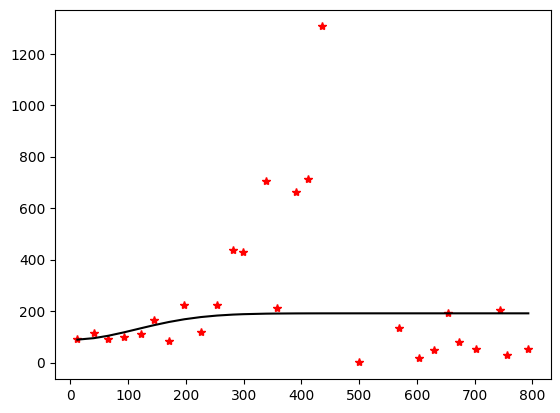

In [1138]:
OKResidual = OrdinaryKriging(Rvals.elev.astype(float), Rvals.lat.astype(float), Rvals.residuals.astype(float), 
                        variogram_model='gaussian',
                        verbose=False,
                        enable_plotting=True,
                            nlags= 30)

In [1473]:
Latitude = np.arange(Rvals.lat.min(), Rvals.lat.max(), 0.1)
elevation = np.arange(Rvals.elev.min(), Rvals.elev.max(), 10)

# Latitude, elevation = np.meshgrid(Latitude, elevation)

In [1474]:
R_residual_pred, ss = OKResidual.execute("grid",Latitude, elevation)

In [1469]:
Latitude, elevation = np.meshgrid(Latitude, elevation)

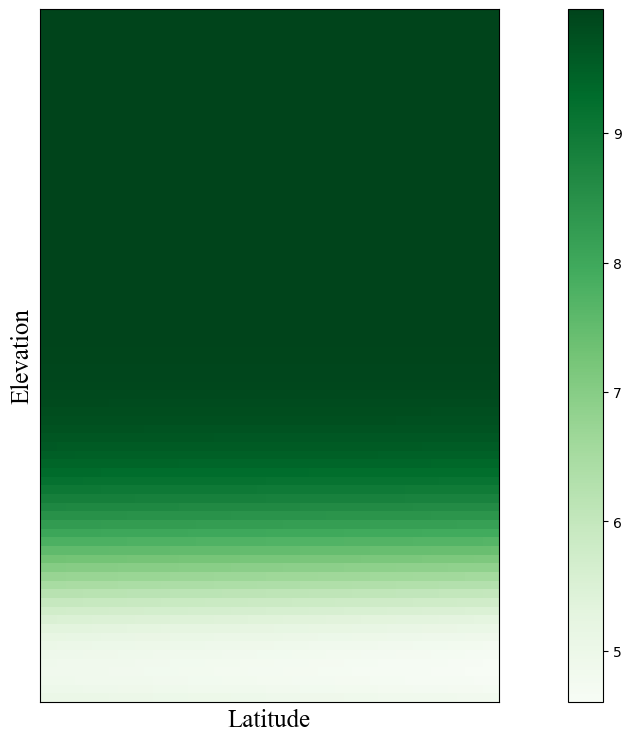

In [1482]:
plt.subplots(1, figsize = [18, 9])
plt.imshow(R_residual_pred, origin = 'lower', cmap = 'Greens')
plt.colorbar()
plt.xlabel("Latitude", 
          fontsize= 18, fontname = "times new roman")

plt.ylabel("Elevation", 
          fontsize= 18, fontname = "times new roman")
plt.gca().xaxis.set_tick_params(labelbottom=False, bottom = False)
plt.gca().yaxis.set_tick_params(labelleft=False, left = False)
plt.show()


In [1197]:
R_total_values = R_residual_pred

for row in bar(range(Latitude.shape[0])):
    for col in range(Latitude.shape[1]):
        inputs = np.array([Latitude[row, col], elevation[row, col]]).reshape(1, -1)
        inputs = scaleX.transform(inputs)
        
        prediction = netR(torch.Tensor(inputs))
        prediction = prediction.detach().numpy()
        prediction = scaleR.inverse_transform(prediction)
        R_total_values[row, col] += np.abs(prediction)

  0%|          | 0/80 [00:00<?, ?it/s]

In [1508]:
scalelat = MinMaxScaler(feature_range=[-10, 10])
scaleelev = MinMaxScaler(feature_range=[-5, 5])

Par1 = scalelat.fit_transform(Rvals.lat.to_numpy().reshape(-1, 1))
Par2 = scaleelev.fit_transform(Rvals.elev.to_numpy().reshape(-1, 1))

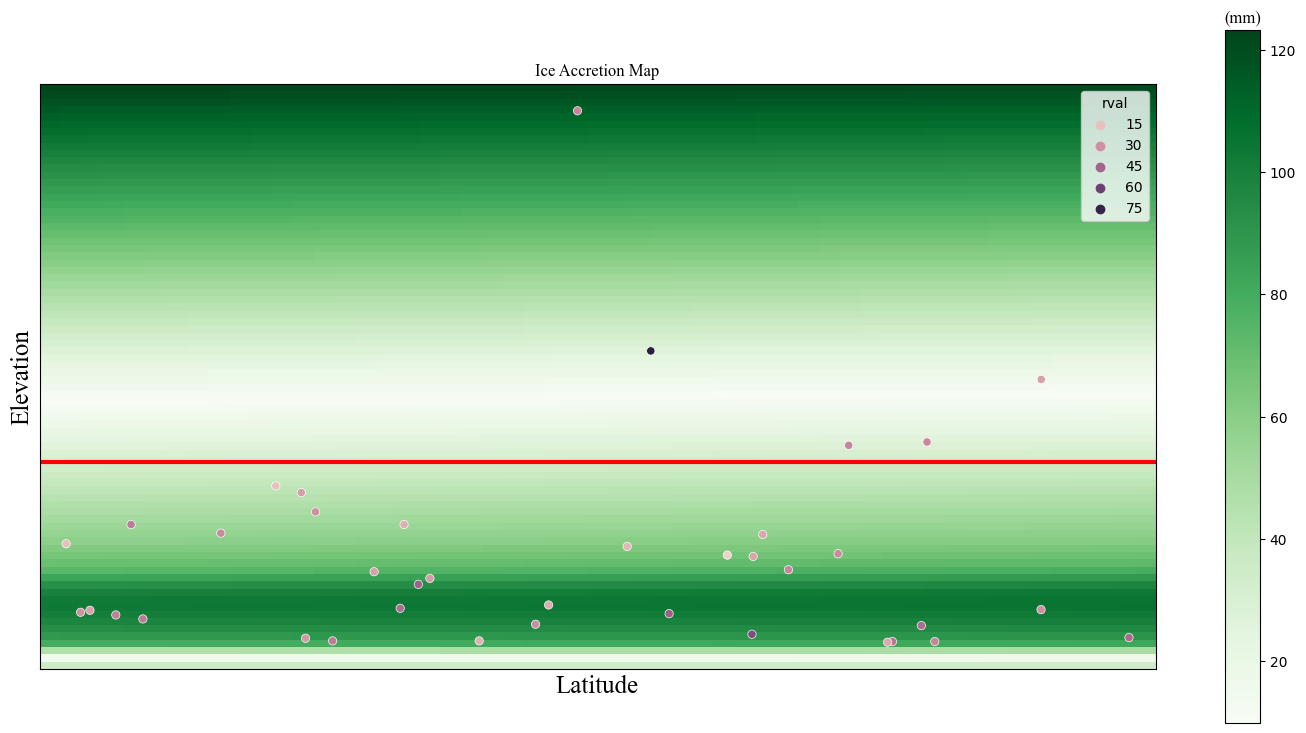

In [1532]:
_, ax = plt.subplots(1, figsize = [18, 9])
plt.imshow(R_total_values, origin = 'lower', cmap = 'Greens', extent=[-10.5,10.5,-5.5,5.5])
fig= plt.colorbar()
fig.ax.set_title('(mm)', fontname = 'times new roman')
plt.xlabel("Latitude", 
          fontsize= 18, fontname = "times new roman")
plt.axhline(-1.6, color = 'r', lw = 3)
sns.scatterplot(x = Par1.reshape(-1, ), y = Par2.reshape(-1, ), color = 'r', marker = 'o', ax = ax, hue = Rvals.rval, cmap = 'Reds')
plt.ylabel("Elevation", 
          fontsize= 18, fontname = "times new roman")
plt.gca().xaxis.set_tick_params(labelbottom=False, bottom = False)
plt.gca().yaxis.set_tick_params(labelleft=False, left = False)
plt.title('Ice Accretion Map', fontname = 'times new roman')
plt.show()

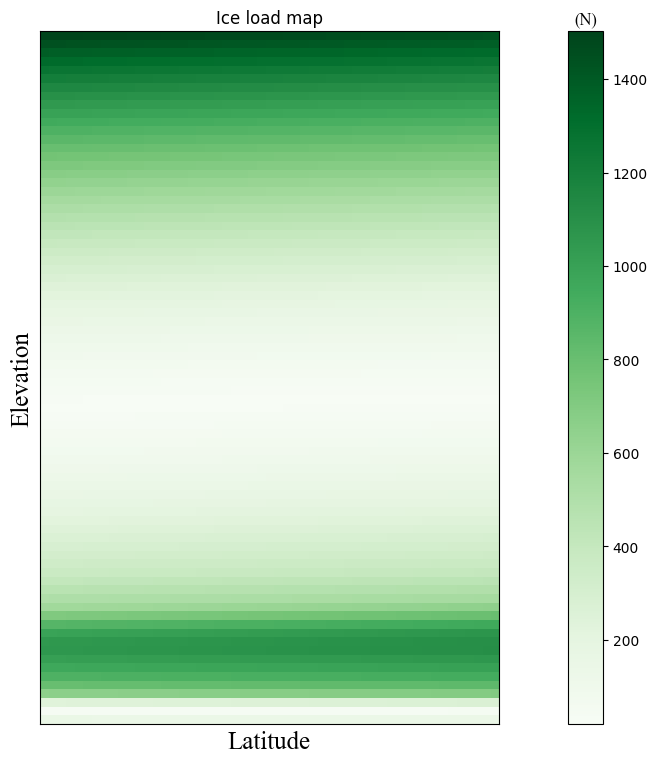

In [1538]:
# Conductor ACSR 410 mm
D_conductor = 22.85e-3
V_mean = 26
ro_ice = 200+20*V_mean

Area_ice = np.pi/4*((D_conductor+2*R_total_values*2/1000)**2 - D_conductor**2)

ice_load = ro_ice*Area_ice


plt.subplots(1, figsize = [18, 9])
plt.imshow(ice_load*10, origin = 'lower', cmap = 'Greens')
fig= plt.colorbar()
fig.ax.set_title('(N)', fontname = 'times new roman')
plt.xlabel("Latitude", 
          fontsize= 18, fontname = "times new roman")

plt.ylabel("Elevation", 
          fontsize= 18, fontname = "times new roman")
plt.gca().xaxis.set_tick_params(labelbottom=False, bottom = False)
plt.gca().yaxis.set_tick_params(labelleft=False, left = False)
plt.title('Ice load map')
plt.show()

In [1255]:
# Define the problem statement
input_size = 2
output_size = 1
hidden_layers = 2
activation = nn.ReLU()
initialization = nn.init.xavier_uniform_
loss_fn = nn.MSELoss()
optimizer = optim.Adam

epochs = 400
val_ratio = 0.15
test_ratio = 0.15

In [1285]:
X = Vvals.iloc[:, [2, 3]].to_numpy()

V = Vvals.iloc[:, -3].to_numpy().reshape(-1, 1)
V[2] += 10
scaleX = MinMaxScaler()
scaleR = MinMaxScaler()

X = scaleX.fit_transform(X)
V = scaleR.fit_transform(V)

In [1286]:
X_train, x_test, y_train, y_test = train_test_split(X, V, test_size=test_ratio)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio)





In [1287]:
class NetV(nn.Module):
    def __init__(self, n_input, n_output,  n_neurons1, activation_func):
        super(NetV, self).__init__()
        self.fc1 = nn.Linear(n_input, n_neurons1)
        self.fc2 = nn.Linear(n_neurons1, n_neurons1)
        self.fc3 = nn.Linear(n_neurons1, n_output)
        self.activation_func = activation_func
        
    def forward(self, x):
        x = self.activation_func(self.fc1(x))
        x = self.activation_func(self.fc2(x))
        x = self.fc3(x)
        return x

In [1308]:
def objectiveV(trial):
    # Define the number of neurons and learning rate for this trial
    n_neurons1 = trial.suggest_int('n_neurons1', 2, 50)
#     n_neurons2 = trial.suggest_int('n_neurons2', 2, 100)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 25])
    # Define the network architecture
    net = NetV(n_input=2, n_output=1, n_neurons1=n_neurons1, activation_func=nn.ReLU())

    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay = 1e-3)

    
    # Convert the data to PyTorch tensors and create DataLoader objects
    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
    val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val))
    
    train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size= batch_size, shuffle=False)

    # Train the model
    for epoch in range(4_00):
        net.train()
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = net(x_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            
        net.eval()
        with torch.no_grad():
            val_loss = 0
            for x_batch, y_batch in val_loader:
                y_pred = net(x_batch)
                val_loss += criterion(y_pred, y_batch).item() * x_batch.size(0)
            val_loss /= len(val_loader.dataset)
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    
    return val_loss

In [1309]:
if __name__ == '__main__':
    study = optuna.create_study(direction='minimize')
    study.optimize(objectiveV, n_trials=100)
    
    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial
    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-04-24 09:48:26,935] A new study created in memory with name: no-name-1fecb49d-8dad-436b-9bcc-e0b6ce5ff5e0
[I 2023-04-24 09:48:27,424] Trial 0 finished with value: 0.06383703649044037 and parameters: {'n_neurons1': 14, 'lr': 0.0033703362587097583, 'batch_size': 64}. Best is trial 0 with value: 0.06383703649044037.
[I 2023-04-24 09:48:28,268] Trial 1 finished with value: 0.06802669912576675 and parameters: {'n_neurons1': 49, 'lr': 0.004452664787238759, 'batch_size': 25}. Best is trial 0 with value: 0.06383703649044037.
[I 2023-04-24 09:48:29,120] Trial 2 finished with value: 0.06427288800477982 and parameters: {'n_neurons1': 48, 'lr': 0.0008347794197743534, 'batch_size': 25}. Best is trial 0 with value: 0.06383703649044037.
[I 2023-04-24 09:48:29,634] Trial 3 finished with value: 0.7365505695343018 and parameters: {'n_neurons1': 15, 'lr': 8.96705835606279e-05, 'batch_size': 32}. Best is trial 0 with value: 0.06383703649044037.
[I 2023-04-24 09:48:30,131] Trial 4 finished with val

Number of finished trials:  100
Best trial:
  Value:  0.06314154714345932
  Params: 
    n_neurons1: 2
    lr: 0.003764320288989059
    batch_size: 25


In [1310]:
print("Number of finished trials:", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    

Number of finished trials: 100
Best trial:
  Value:  0.06314154714345932
  Params: 
    n_neurons1: 2
    lr: 0.003764320288989059
    batch_size: 25


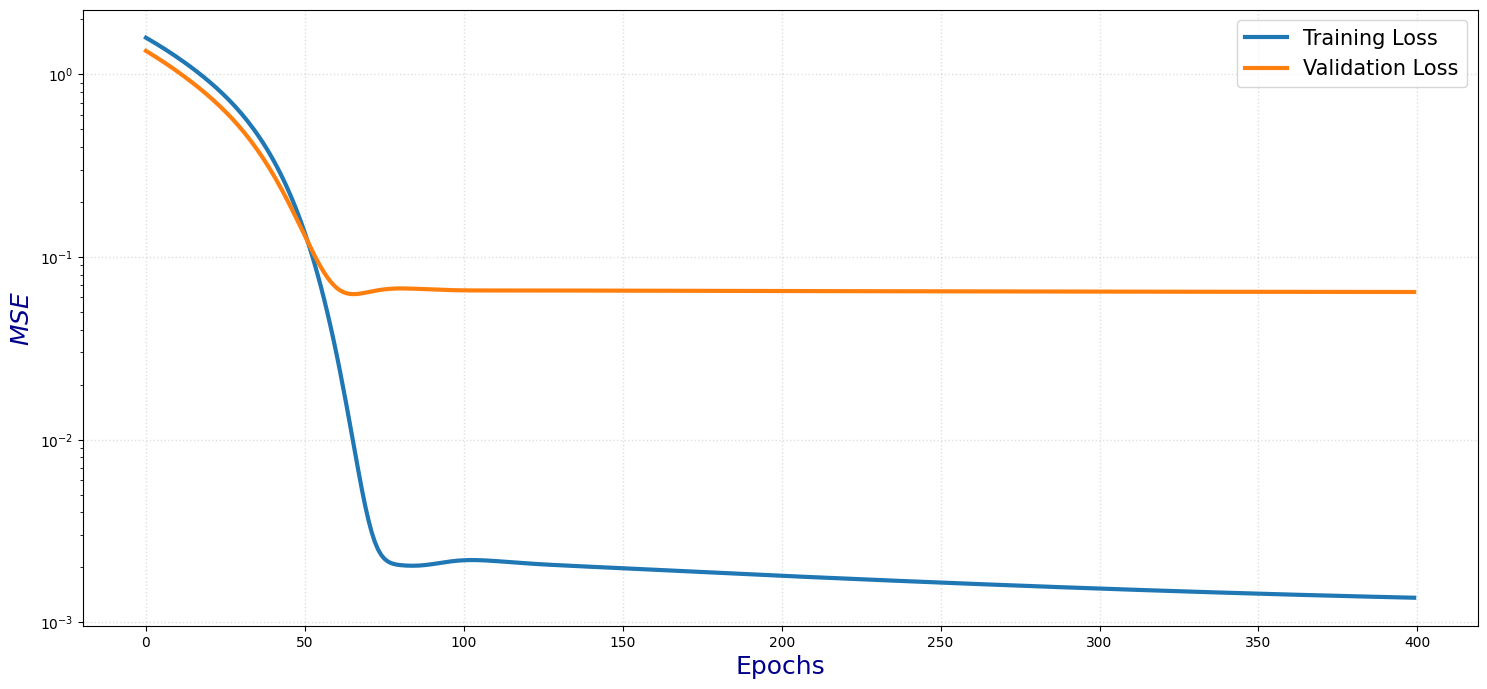

In [1328]:
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
val_dataset = TensorDataset(torch.Tensor(X_val), torch.Tensor(y_val))
train_loader = DataLoader(train_dataset, batch_size= trial.params['batch_size'])
val_loader = DataLoader(val_dataset, batch_size= trial.params['batch_size'])


netv = NetV(n_input=2, n_output=1, \
          n_neurons1=trial.params['n_neurons1'],\
          activation_func=nn.ReLU())

criterion = nn.MSELoss()
optimizer = optim.Adam(netv.parameters(), lr=trial.params['lr'], weight_decay = 1e-3)


train_losses, val_losses = [], []
for epoch in range(4_00):
    train_loss = 0.0
    valid_loss = 0.0
    netR.train()
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = netv(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x_batch.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
        
    netv.eval()
    with torch.no_grad():
        val_loss = 0
        for x_batch, y_batch in val_loader:
            y_pred = netv(x_batch)
            valid_loss += criterion(y_pred, y_batch).item() * x_batch.size(0)
        valid_loss /= len(val_loader.dataset)
        val_losses.append(valid_loss)
#     print(f"Epoch {epoch}: train_loss={train_losses[-1]:.4f} val_loss={val_loss:.4f}")
    
# Plot the training and validation loss curves
import matplotlib.pyplot as plt
_, ax = plt.subplots(1, figsize= [18, 8])

plt.plot(train_losses, label='Training Loss', lw= 3)
plt.plot(val_losses, label='Validation Loss', lw= 3)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid("grey", linestyle = ":",
        alpha = 0.4, linewidth = 1)
plt.xlabel("Epochs", c="darkblue", size=18)
plt.ylabel("$MSE$", c="darkblue", size=18)
plt.legend(loc="upper right", prop={"size":15})
plt.show()

In [1330]:
pred_train = netv(torch.Tensor(X_train))
pred_test = netv(torch.Tensor(x_test))

pred_train = pred_train.detach().numpy().reshape(-1, 1)
pred_test = pred_test.detach().numpy().reshape(-1, 1)

mse_train, mae_train, r2_train = mse(pred_train, y_train), mae(pred_train, y_train), r2(pred_train, y_train)
mse_test, mae_test, r2_test = mse(pred_test, y_test), mae(pred_test, y_test), r2(pred_test, y_test)

print(f"Train:\n\t mse: {mse_train:.3f}, mae: {mae_train:.3f}, r2: {r2_train*100:.2f}٪")
print(f"Test:\n\t mse: {mse_test:.3f}, mae: {mae_test:.3f}, r2: {r2_test*100:.2f}٪")

Train:
	 mse: 0.001, mae: 0.015, r2: 54.46٪
Test:
	 mse: 0.171, mae: 0.226, r2: 53.20٪


In [1332]:
Xin = Vvals.iloc[:, [2, 3]]
Xin = scaleX.fit_transform(Xin)
Xin = torch.Tensor(Xin)
pred = netR(Xin)
pred = pred.detach().numpy().reshape(-1, 1)
pred = scaleR.inverse_transform(pred)
Vvals['residuals'] = Vvals.MRI50.to_numpy().reshape(-1, 1) - pred

In [1563]:
scalenew = MinMaxScaler(feature_range=[0, 10])
ttemp = Vvals.residuals.to_numpy().reshape(-1, 1)
ttemp = Vvals.loc[Vvals.residuals > 1]


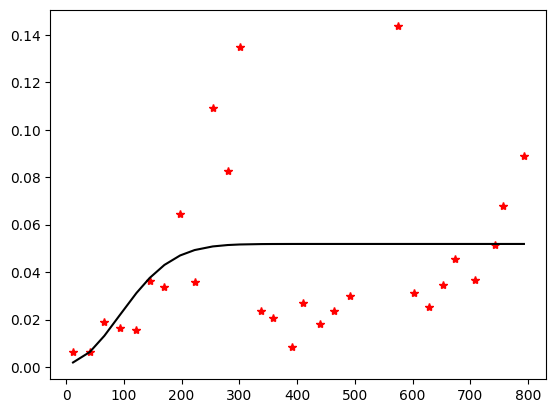

In [1564]:
OKResidualV = OrdinaryKriging(ttemp.elev.astype(float), ttemp.lat.astype(float), ttemp.residuals.astype(float), 
                        variogram_model='gaussian',
                        verbose=False,
                        enable_plotting=True,
                        nlags= 30)

In [1578]:
Latitude = np.arange(Rvals.lat.min(), Rvals.lat.max(), 0.1)
elevation = np.arange(Rvals.elev.min(), Rvals.elev.max(), 10)

# Latitude, elevation = np.meshgrid(Latitude, elevation)

In [1579]:
V_residual_pred, ss = OKResidualV.execute("grid",Latitude, elevation)

In [1580]:
Latitude, elevation = np.meshgrid(Latitude, elevation)

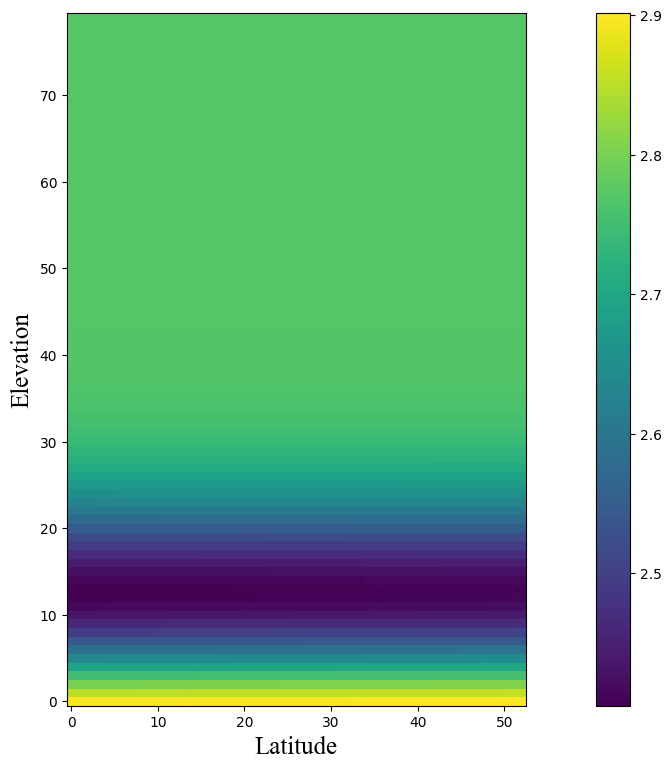

In [1581]:
plt.subplots(1, figsize = [18, 9])
plt.imshow(V_residual_pred, origin = 'lower')
plt.colorbar()
plt.xlabel("Latitude", 
          fontsize= 18, fontname = "times new roman")

plt.ylabel("Elevation", 
          fontsize= 18, fontname = "times new roman")
plt.show()


In [1582]:
V_total_values = V_residual_pred.data

for row in bar(range(Latitude.shape[0])):
    for col in range(Latitude.shape[1]):
        inputs = np.array([Latitude[row, col], elevation[row, col]]).reshape(1, -1)
        inputs = scaleX.transform(inputs)
        
        prediction = netv(torch.Tensor(inputs))
        prediction = prediction.detach().numpy()
        prediction = scaleR.inverse_transform(prediction)
        V_total_values[row, col] += (prediction)
        

  0%|          | 0/80 [00:00<?, ?it/s]

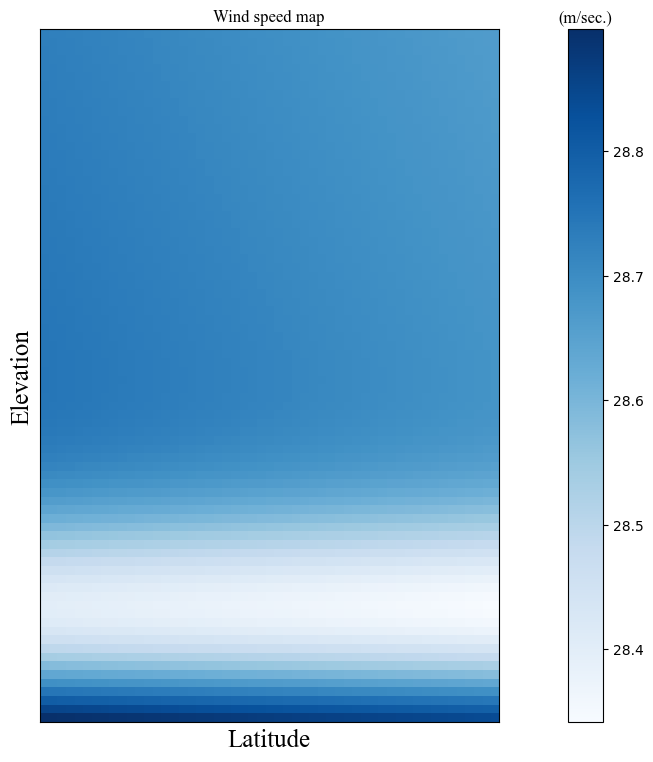

In [1583]:
plt.subplots(1, figsize = [18, 9])
plt.imshow(V_total_values, origin = 'lower', cmap = 'Blues')
fig= plt.colorbar()
fig.ax.set_title('(m/sec.)', fontname = 'times new roman')
plt.xlabel("Latitude", 
          fontsize= 18, fontname = "times new roman")

plt.ylabel("Elevation", 
          fontsize= 18, fontname = "times new roman")
plt.gca().xaxis.set_tick_params(labelbottom=False, bottom = False)
plt.gca().yaxis.set_tick_params(labelleft=False, left = False)
plt.title('Wind speed map', fontname = "times new roman")
plt.show()

In [1584]:
# Conductor ACSR 410 mm2
D_conductor = 22.85e-3
drag_coefficient = 0.8
ice_mean = R_total_values.mean()
ro_air = 1.225

V_laod = np.zeros(V_total_values.shape)

for row in range(V_total_values.shape[0]):
    for col in range(V_total_values.shape[1]):
        V_load[row, col] = 1/2*ro_air*drag_coefficient*V_total_values[row, col]**2*(2*R_total_values[row, col]/1e3 + D_conductor)

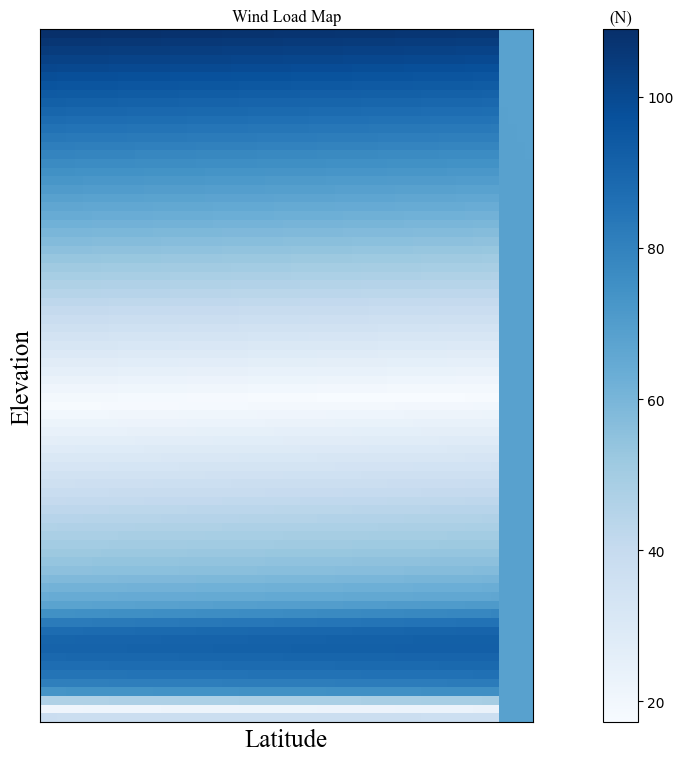

In [1586]:
plt.subplots(1, figsize = [18, 9])
plt.imshow(V_load, origin = 'lower', cmap = 'Blues')
fig= plt.colorbar()
fig.ax.set_title('(N)', fontname = 'times new roman')
plt.xlabel("Latitude", 
          fontsize= 18, fontname = "times new roman")

plt.ylabel("Elevation", 
          fontsize= 18, fontname = "times new roman")
plt.gca().xaxis.set_tick_params(labelbottom=False, bottom = False)
plt.gca().yaxis.set_tick_params(labelleft=False, left = False)
plt.title('Wind Load Map', fontname = "times new roman")
plt.show()

In [637]:
X = Vextremes.iloc[:, [1, 2]].to_numpy()

V = Vextremes.iloc[:, -1].to_numpy().reshape(-1, 1)

scaleX = MinMaxScaler()
scaleV = MinMaxScaler()

X = scaleX.fit_transform(X)
V = scaleV.fit_transform(V)

In [ ]:
X_train0, x_test0, y_train0, y_test = train_test_split(X, V, test_size=test_ratio)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio)





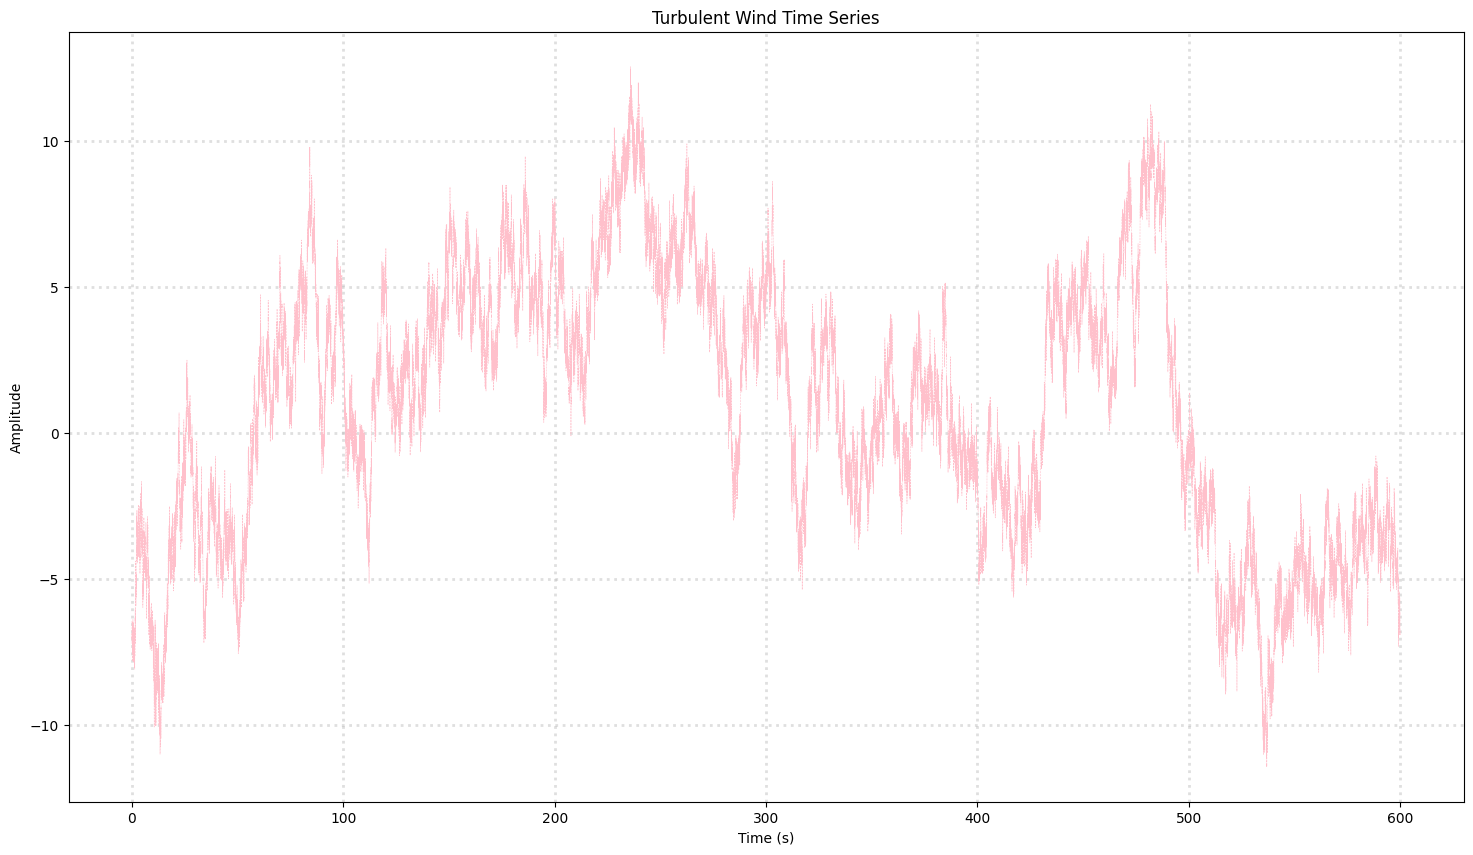

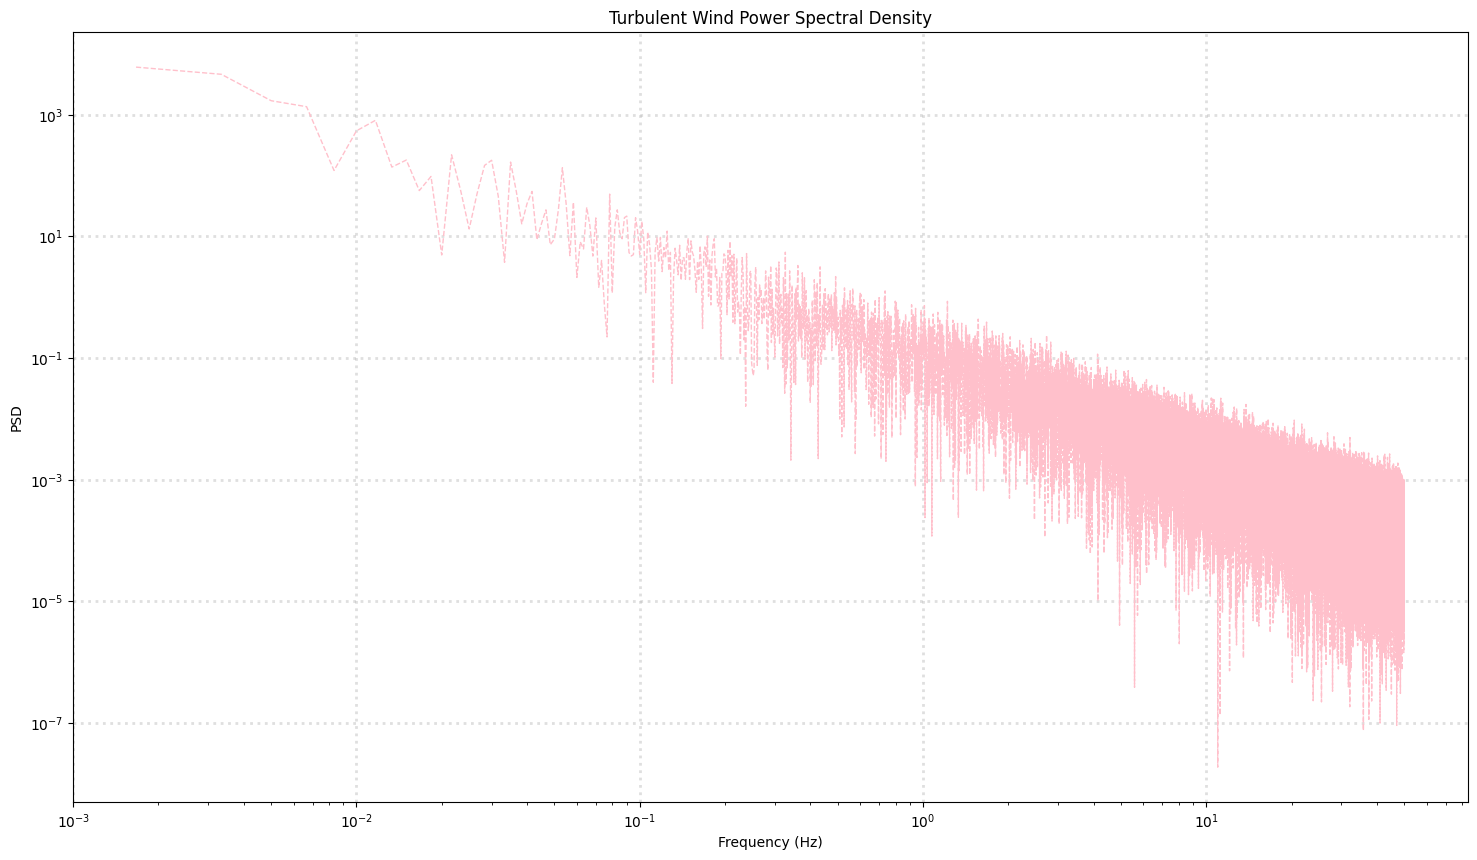

In [714]:
np.random.seed(123)
# Define parameters
dt = 0.01  # time step
T = 600  # total time (s)
N = int(T / dt)  # number of time steps
f0 = 1 / T  # lowest frequency
fN = 0.5 / dt  # Nyquist frequency
f = np.linspace(f0, fN, N // 2 + 1)  # frequency array
alpha = -5 / 3  # power-law exponent
A = 0.08  # amplitude

# Generate random complex numbers with normal distribution
noise = np.random.randn(N // 2 + 1) + 1j * np.random.randn(N // 2 + 1)

# Generate random phase angles
phase = np.exp(1j * 2 * np.pi * np.random.rand(N // 2 + 1))

# Compute PSD
S = A * np.abs(noise * phase) ** 2 * f ** alpha

# Compute Fourier coefficients
X = np.sqrt(S * (fN - f0))

# Generate random phases
phase = np.exp(1j * 2 * np.pi * np.random.rand(N // 2 + 1))

# Compute Fourier coefficients
X = X * phase

# Compute inverse Fourier transform
x = np.fft.irfft(X) * np.sqrt(N)

# Create time array
t = np.arange(N) * dt

# Plot time series
plt.figure(figsize = [18, 10])
plt.plot(t, x, '--', lw=0.4, color='pink')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Turbulent Wind Time Series')
plt.grid("grey", linestyle = ":",
        alpha = 0.4, linewidth = 2)
# Plot PSD
plt.figure(figsize = [18, 10])
plt.loglog(f, S, '--', lw=1, color='pink')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.title('Turbulent Wind Power Spectral Density')
plt.grid("grey", linestyle = ":",
        alpha = 0.4, linewidth = 2)
plt.show()


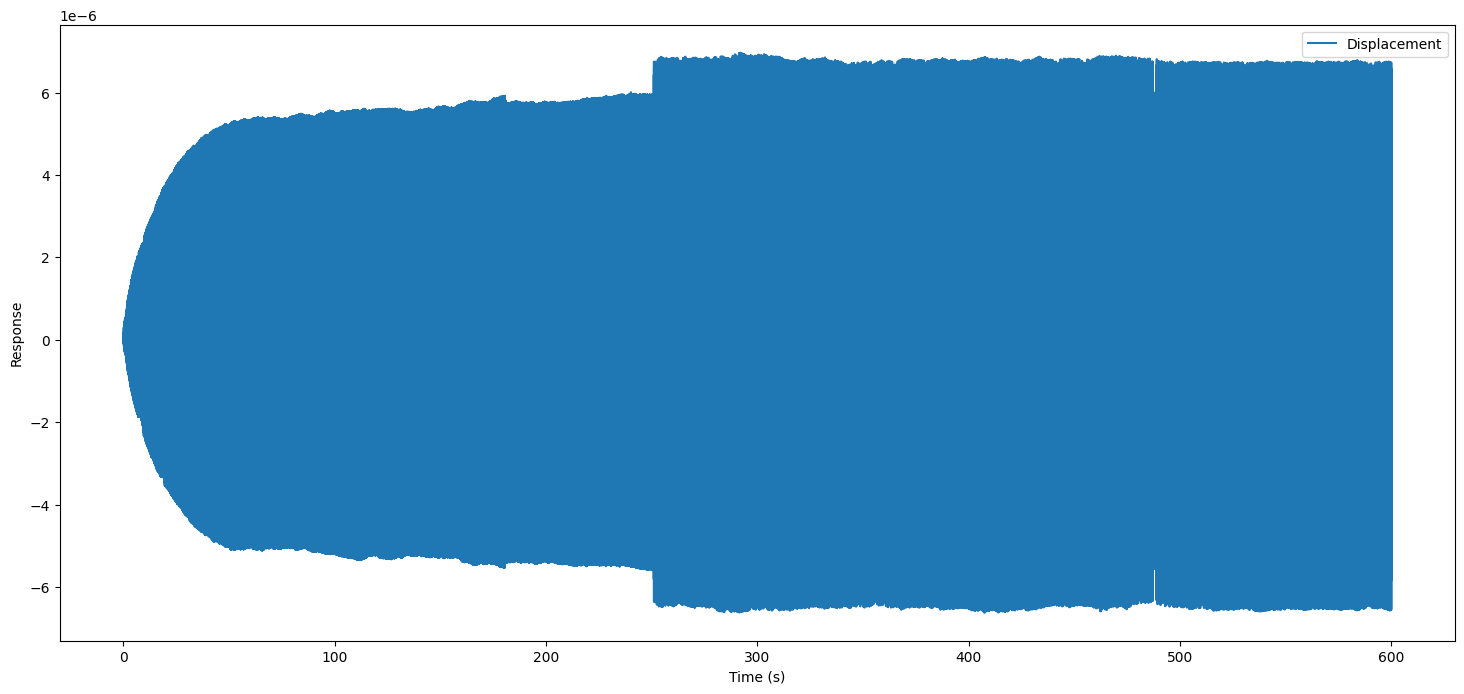

In [1588]:
# Define system parameters
m = 378000  # mass in kg
k = 1.2e10  # stiffness in N/m
c = 3778.43  # damping coefficient in N/(m/s)

# Define the differential equation governing the motion of the system
def eq_of_motion(t, y):
    """
    t: time
    y: array of system state [x, v] where x is displacement and v is velocity
    """
    x, v = y  # unpack state
    dxdt = v
    dvdt = (-k*x - c*v + F(t))/m  # F(t) is the time history load
    return [dxdt, dvdt]

# Define the time history load function (you can use your own function here)
def F(t):
    try:
        index = int(t/dt)
        return Fw[index]
    except:
        return 0
    
# Define initial conditions
x0 = 0.0  # initial displacement
v0 = 0.0  # initial velocity
y0 = [x0, v0]

# Define time span and time step
t0 = 0.0  # initial time
t_end = 600.0  # end time
dt = t_end/Fw.shape[0]  # time step

# Create a RK45 integrator object and set initial conditions
integrator = RK45(eq_of_motion, t0, y0, t_end, rtol=1e-6, atol=1e-6)

# Initialize arrays to store the solution
time = [t0]
disp = [x0]
vel = [v0]

# Integrate the system using the RK45 method
while integrator.t < t_end:
    integrator.step()
    time.append(integrator.t)
    disp.append(integrator.y[0])
    vel.append(integrator.y[1])

# Plot the solution
import matplotlib.pyplot as plt
plt.subplots(1, figsize=[18, 8])
plt.plot(time, disp, label='Displacement')
# plt.plot(time, vel, label='Velocity')
plt.xlabel('Time (s)')
plt.ylabel('Response')
plt.legend()
plt.show()


In [783]:
def von_karman_spectrum(f, L, u_mean, I):
    """Compute the von Kármán spectrum.
    
    Parameters
    ----------
    f : array_like
        Frequency (Hz).
    L : float
        Integral length scale (m).
    u_mean : float
        Mean wind speed (m/s).
    I : float
        Turbulent intensity (-).
    
    Returns
    -------
    array_like
        PSD (m^2/s^2/Hz).
    """
    f0 = 1.0 / L  # frequency rolloff
    sigma_u = u_mean * I  # standard deviation of wind speed fluctuations
    alpha = 6.0 / 5.0  # von Kármán constant
    return (4 * alpha * sigma_u**2 * L / u_mean * (1 + (f / f0)**2)**(-5/6))


In [787]:


N = 2**14  # number of points in time series
dt = 0.1  # time step (s)
t = np.arange(N) * dt

f = fftpack.fftfreq(N, dt)  # frequency (Hz)
S = von_karman_spectrum(f, L=90, u_mean=33, I=0.14)  # PSD (m^2/s^2/Hz)

A = np.sqrt(2 * S * np.abs(f[1] - f[0]))  # amplitude (m/s)
phi = 2 * np.pi * np.random.rand(len(f))  # phase (rad)
F = A * np.exp(1j * phi)  # complex Fourier coefficients

u = np.real(fftpack.ifft(F))  # time series of wind speed (m/s)
u = np.clip(u, 0, 10)  # limit wind speed


In [788]:
def log_wind_profile(z, z0, u_star, u_ref=33):
    """Compute the wind speed at height z using the logarithmic wind profile.
    
    Parameters
    ----------
    z : array_like
        Height above ground level (m).
    z0 : float
        Roughness length (m).
    u_star : float
        Friction velocity (m/s).
    u_ref : float, optional
        Reference wind speed (m/s), defaults to 33.
    
    Returns
    -------
    array_like
        Wind speed at height z (m/s).
    """
    kappa = 0.4  # von Kármán constant
    u = u_star / kappa * np.log(z / z0) + u_ref
    return u


In [1589]:
heights = [45, 90, 110, 130, 150]
new_winds = 23.26*(np.array(heights)/10)**0.16
new_winds

array([29.58855202, 33.05890861, 34.137565  , 35.06231981, 35.87437238])

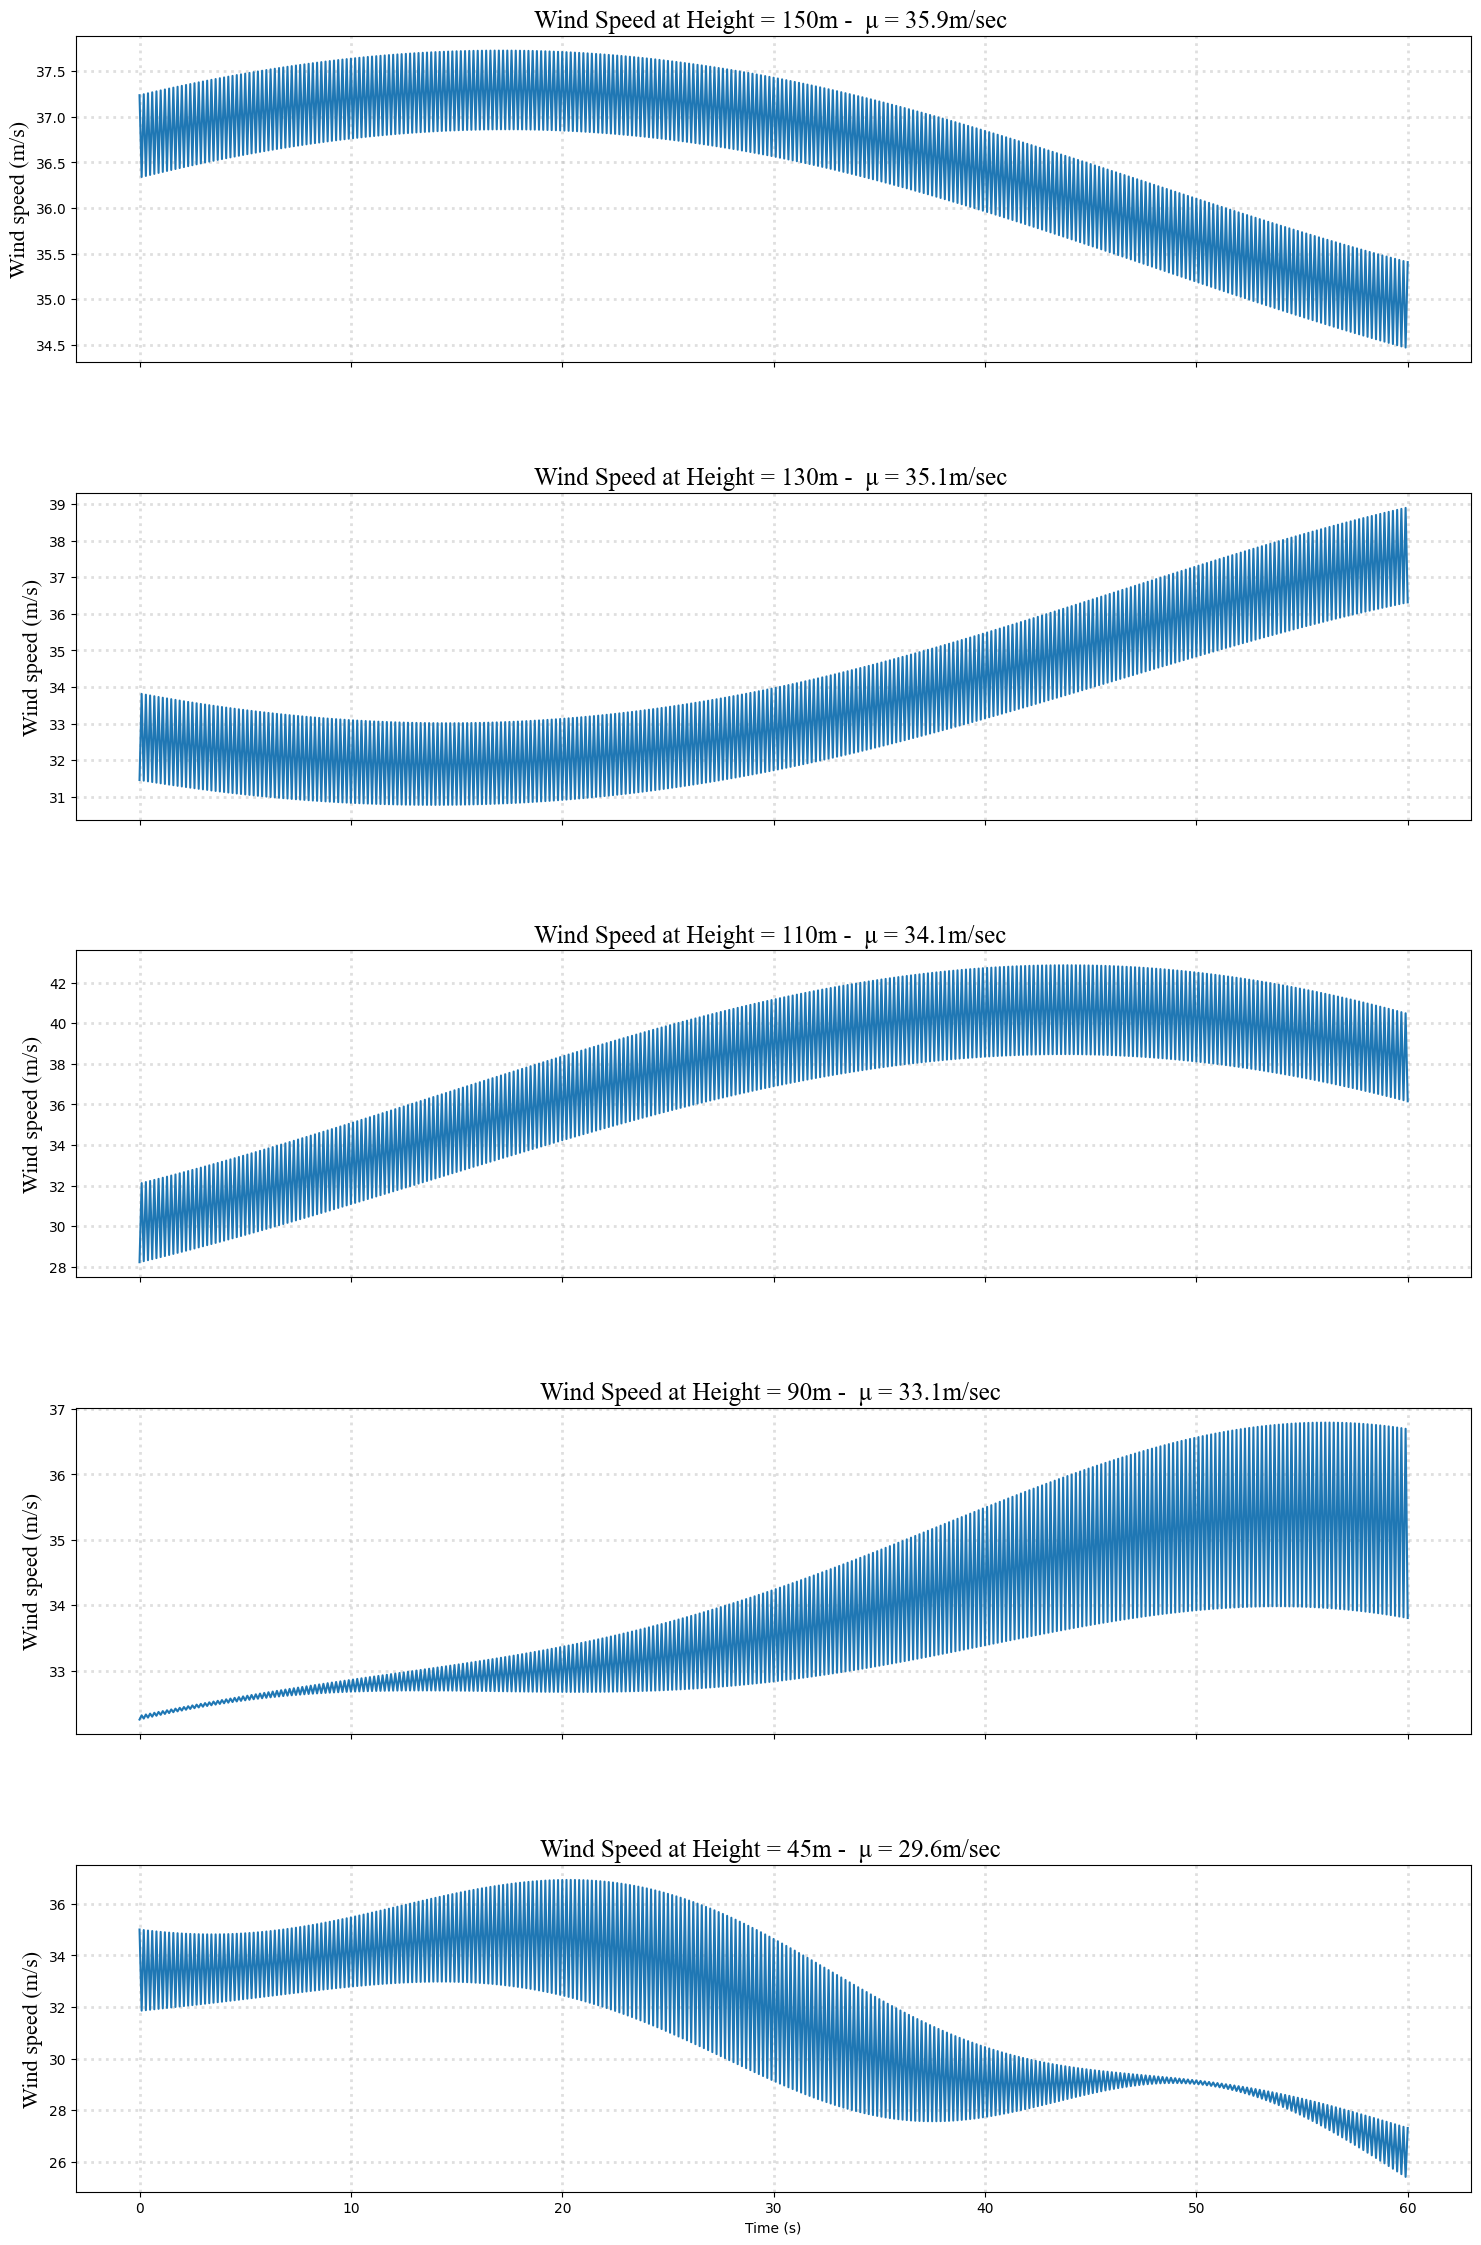

In [1591]:
np.random.seed(123)
# Define input parameters
turb_intensity = 0.15
mean_wind_speed = 33.0
duration = 600.0
heights = [45, 90, 110, 130, 150]
l_scale = 1200.0

# Calculate variance of turbulence
turb_variance = (turb_intensity * mean_wind_speed) ** 2

# Generate wave numbers
num_points = int(600) + 1
k = np.fft.fftfreq(num_points, d=duration / (num_points - 1)) * 2 * np.pi

# Generate turbulence spectrum based on Kolmogorov spectrum
kolmogorov_spectrum = (2.0 / 3.0) * (turb_variance / l_scale) ** (2.0 / 3.0) * k ** (-5.0 / 3.0)
kolmogorov_spectrum[0] = 0.0
kolmogorov_spectrum[num_points // 2] = 0.0

# Generate turbulence field at different heights
turb_field = np.zeros((num_points, len(heights)))
for i, height in enumerate(heights):
    alpha = np.random.normal(size=num_points // 2 + 1) + 1j * np.random.normal(size=num_points // 2 + 1)
    alpha[0] = np.real(alpha[0])
    alpha[num_points // 2] = np.real(alpha[num_points // 2])
    alpha *= np.sqrt(kolmogorov_spectrum[:num_points // 2 + 1])
    alpha *= np.sqrt(1.0 - np.exp(-(height / l_scale) ** (2.0 / 3.0)))
    alpha *= np.exp(-0.5 * (k[:num_points // 2 + 1] * height) ** 2)
    alpha_full = np.concatenate((alpha, np.conj(alpha[-2:0:-1])))
    turb_field[:, i] = np.fft.irfft(alpha_full)[:num_points]

# Normalize turbulence field to turbulent intensity and mean wind speed
turb_field *= np.sqrt(2.0 * turb_variance / np.sum(turb_field ** 2) * num_points)
turb_field = turb_field + new_winds



# Plot turbulence time series for all heights
fig, axs = plt.subplots(len(heights), 1, figsize=(18, 28), sharex=True)

plt.subplots_adjust(wspace=0.4,
                    hspace=0.4)
for i, height in reversed(list(enumerate(heights))):
    axs[4 - i].plot(np.arange(num_points) / 10, turb_field[:, i])
    axs[4 - i].set_ylabel('Wind speed (m/s)', fontname = 'times new roman', fontsize = 16)
    axs[4 - i].set_title(f'Wind Speed at Height = {height}m -  \u03BC = {new_winds[i]:.1f}m/sec ', fontname=  'times new roman', fontsize = 18)
    axs[4 - i].grid("grey", linestyle = ":", alpha = 0.4, linewidth = 2)
plt.xlabel('Time (s)')
plt.show()


In [1622]:
drag_coefficient = np.array([0.8, 0.8, 0.8, 1, 1])
element_length = np.array([45, 45, 20, 20, 20])
element_area = np.array([np.pi/4*(9)**2, np.pi/4*(9)**2, 2*0.25, 2*0.25, 2*0.25])



F = 1/2*1.225*new_winds**2*drag_coefficient*element_length*element_area

In [1623]:
if turb_field.shape[0]>turb_field.shape[1]:
    turb_field = turb_field.T
    
force = np.zeros(turb_field.shape)

In [1624]:
for row in range(drag_coefficient.shape[0]):
    force[row, :] = 1/2*1.225*drag_coefficient[row]*turb_field[row, :]**2*element_length[row]*element_area[row]

In [1625]:
if force.shape[0]>5:
    force = force.T

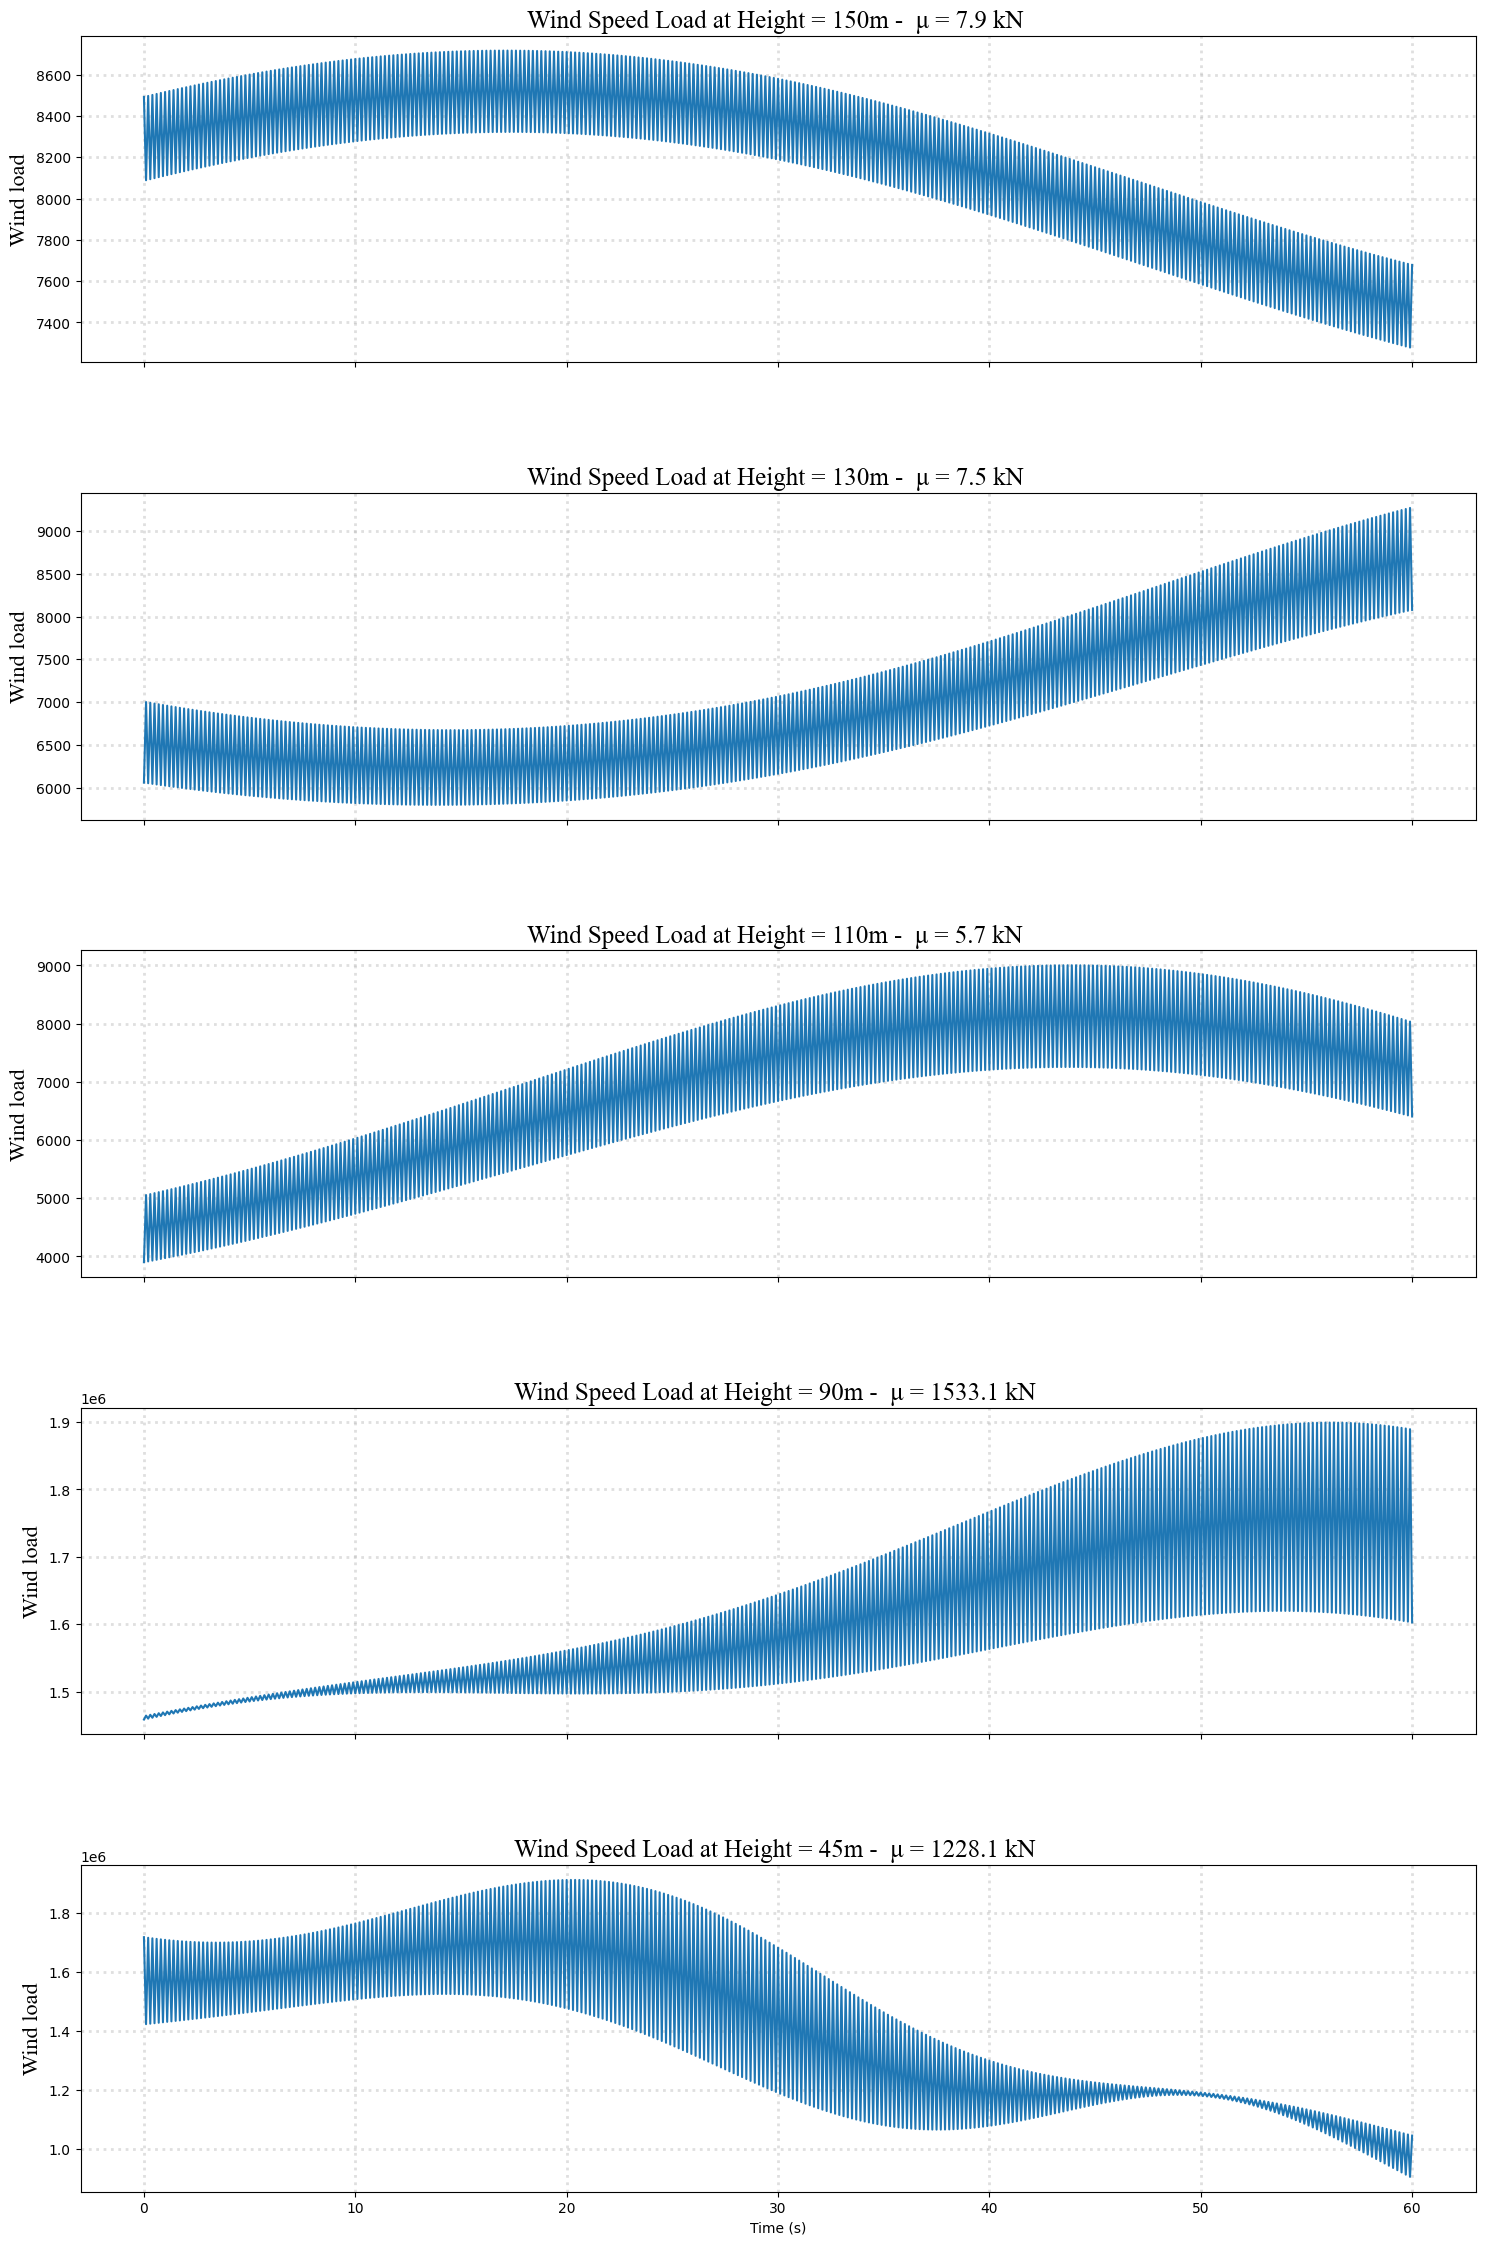

In [1626]:
# Plot turbulence time series for all heights
fig, axs = plt.subplots(len(heights), 1, figsize=(18, 28), sharex=True)

plt.subplots_adjust(wspace=0.4,
                    hspace=0.4)
for i, height in reversed(list(enumerate(heights))):
    axs[4 - i].plot(np.arange(num_points) / 10, force[i, :])
    axs[4 - i].set_ylabel('Wind load', fontname = 'times new roman', fontsize = 16)
    axs[4 - i].set_title(f'Wind Speed Load at Height = {height}m -  \u03BC = {F[i]/1e3:.1f} kN ', fontname=  'times new roman', fontsize = 18)
    axs[4 - i].grid("grey", linestyle = ":", alpha = 0.4, linewidth = 2)
plt.xlabel('Time (s)')
plt.show()